# Sepssis Development During ICU Period Prediction

Sepsis is a life-threatening infection that can develop from staying in Intensive Care Units (ICU), occurring when the infection-fighting processes damage the body's own organs. During the COVID-19 pandemic, ICUs need to focus on this problem more than ever, increasing the need to monitor patients' status regarding their infection risk. Therefore, the goal of this notebook is to build a machine learning model that can predict the probability of a patient developing an infection based on a provided dataset. 

This notebook utilizes various libraries, including analytical and visualization tools like numpy, pandas, matplotlib, and seaborn, as well as machine learning models and data processor from scikit-learn. Since our objective is to predict the outcome of Sepsis, the models employed are binary classifiers, specifically Logistic Regression K-Nearest Neighbor and Random Forest Classier.



## Import Libraries

In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer  

from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score, matthews_corrcoef
from sklearn.metrics import precision_score, auc, roc_auc_score, roc_curve, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint
from imblearn.over_sampling import SMOTE

# Style
from IPython.display import display

# Ignore Warning
import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline


## 1. LOAD DATA AND GENERAL OVERVIEW

In [4]:
# Load data
patients_df = pd.read_csv(r'datasets/Paitients_Files_Train.csv')

# General overview upon the df
print('\n____________ Dataset info ____________')
display(patients_df.info())              
print('\n____________ Statistics of numeric features ____________')
display(patients_df.describe()) 
print('\n____________ Some first data examples ____________')
patients_df.head(5)


____________ Dataset info ____________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         599 non-null    object 
 1   PRG        599 non-null    int64  
 2   PL         599 non-null    int64  
 3   PR         599 non-null    int64  
 4   SK         599 non-null    int64  
 5   TS         599 non-null    int64  
 6   M11        599 non-null    float64
 7   BD2        599 non-null    float64
 8   Age        599 non-null    int64  
 9   Insurance  599 non-null    int64  
 10  Sepssis    599 non-null    object 
dtypes: float64(2), int64(7), object(2)
memory usage: 51.6+ KB


None


____________ Statistics of numeric features ____________


PRG          PL          PR          SK          TS         M11  \
count  599.000000  599.000000  599.000000  599.000000  599.000000  599.000000   
mean     3.824708  120.153589   68.732888   20.562604   79.460768   31.920033   
std      3.362839   32.682364   19.335675   16.017622  116.576176    8.008227   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000   99.000000   64.000000    0.000000    0.000000   27.100000   
50%      3.000000  116.000000   70.000000   23.000000   36.000000   32.000000   
75%      6.000000  140.000000   80.000000   32.000000  123.500000   36.550000   
max     17.000000  198.000000  122.000000   99.000000  846.000000   67.100000   

              BD2         Age   Insurance  
count  599.000000  599.000000  599.000000  
mean     0.481187   33.290484    0.686144  
std      0.337552   11.828446    0.464447  
min      0.078000   21.000000    0.000000  
25%      0.248000   24.000000    0.000000  
50%      0.383000   29.000000    1.000000  
75%      0.647000   40.000000    1.000000  
max      2.420000   81.000000    1.000000


____________ Some first data examples ____________


ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance   Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0  Positive
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0  Negative
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1  Positive
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1  Negative
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1  Positive

#### Observation 1:
- The data has *599 entries* and 11 columns for 11 different features with the last one is the result of `sepssis`.
- No columns has **missing values**

## 2. EXPLORATORY DATA ANALYSIS (EDA)

### 2.1. EDA Utilities
Define utitlity functions to support data visualization

In [8]:
# Function to plot and examine the distribution of numerical attributes
def plot_distribution_box(column, font_scale=3, figsize=(30, 10), tick_label_size=50, color='c'):
    """
    Plot distribution and box using Seaborn. 
    This function is used inside this notebook only and can only be used for patients_df

    Parameters:
    - column: str, name of the column to plot
    - font_scale: float, scale factor for font size
    - figsize: tuple, size of the figure (width, height)
    - tick_label_size: int, size of the tick labels
    - color: diagram color
    
    """
    sns.set(font_scale=font_scale)
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    plt.xticks(fontsize=tick_label_size)
    plt.yticks(fontsize=tick_label_size)
    
    #plot the distribution plot column
    sns.histplot(data=patients_df, x=column, hue='Sepssis', color = color, ax=axes[0], kde=True)
    axes[0].set_title(f'Distribution Plot for {column}')
    axes[0].set_xlabel(f'{column}')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='both', labelsize=12)
    axes[0].axvline(patients_df[column].mean(), color = 'r', linestyle = '--', label = 'Mean', linewidth=2)
    axes[0].axvline(patients_df[column].median(), color = 'g', linestyle = '-', label = 'Median', linewidth=2)
    
    #plot the count plot for column
    sns.boxplot(data=patients_df, x='Sepssis', y=column, hue='Sepssis', ax=axes[1])
    axes[1].set_title(f'Box Plot for {column}')
    axes[1].set_xlabel(f'{column}')
    axes[1].tick_params(axis='both', labelsize=12)
    
    plt.show()

In [9]:
# Function to plot countplot for attributes
def custom_countplot(column, legend_labels=None, order=None, palette=None, x_ticklabels=None, font_scale=1.2, figsize=(8, 6)):
    """
    Plot a count plot using Seaborn with customized legend labels.

    Parameters:
    - column: str, name of the column to plot
    - legend_labels: dict, custom legend labels (key: original value, value: custom label)
    - order: list, order of values on the x-axis
    - palette: str or list, color palette for the plot
    - x_ticklabels: dict, custom x-axis tick labels (key: original value, value: custom label)
    - font_scale: float, scale factor for font size
    - figsize: tuple, size of the figure (width, height)
    """
    sns.set(font_scale=font_scale)
    plt.figure(figsize=figsize)
    
    # Create a count plot with optional order and palette
    plot = sns.countplot(patients_df, x=column, hue='Sepssis', order=order, palette=palette)
    
    # Customize legend labels
    if legend_labels:
        handles, _ = plt.gca().get_legend_handles_labels()
        labels = [legend_labels.get(label, label) for label in plt.gca().get_xticks()]
        plt.legend(handles, labels, title=column, loc='upper right', bbox_to_anchor=(1, 0.9))
    
    # Customize x-axis tick labels
    if x_ticklabels:
        tick_positions = plt.xticks()[0]
        new_ticklabels = [x_ticklabels.get(int(label), label) for label in tick_positions]
        plot.set_xticklabels(new_ticklabels)
        
        
    # Customize labels and title
    plt.title(f'Count Plot for {column}')
    plt.xlabel(f'{column}')
    plt.ylabel('Count')
    plt.show()

### 2.2. Analysis of quantitive variables considering Sepssis status 

#### 2.2.1. Plasma Glucose (PRG)

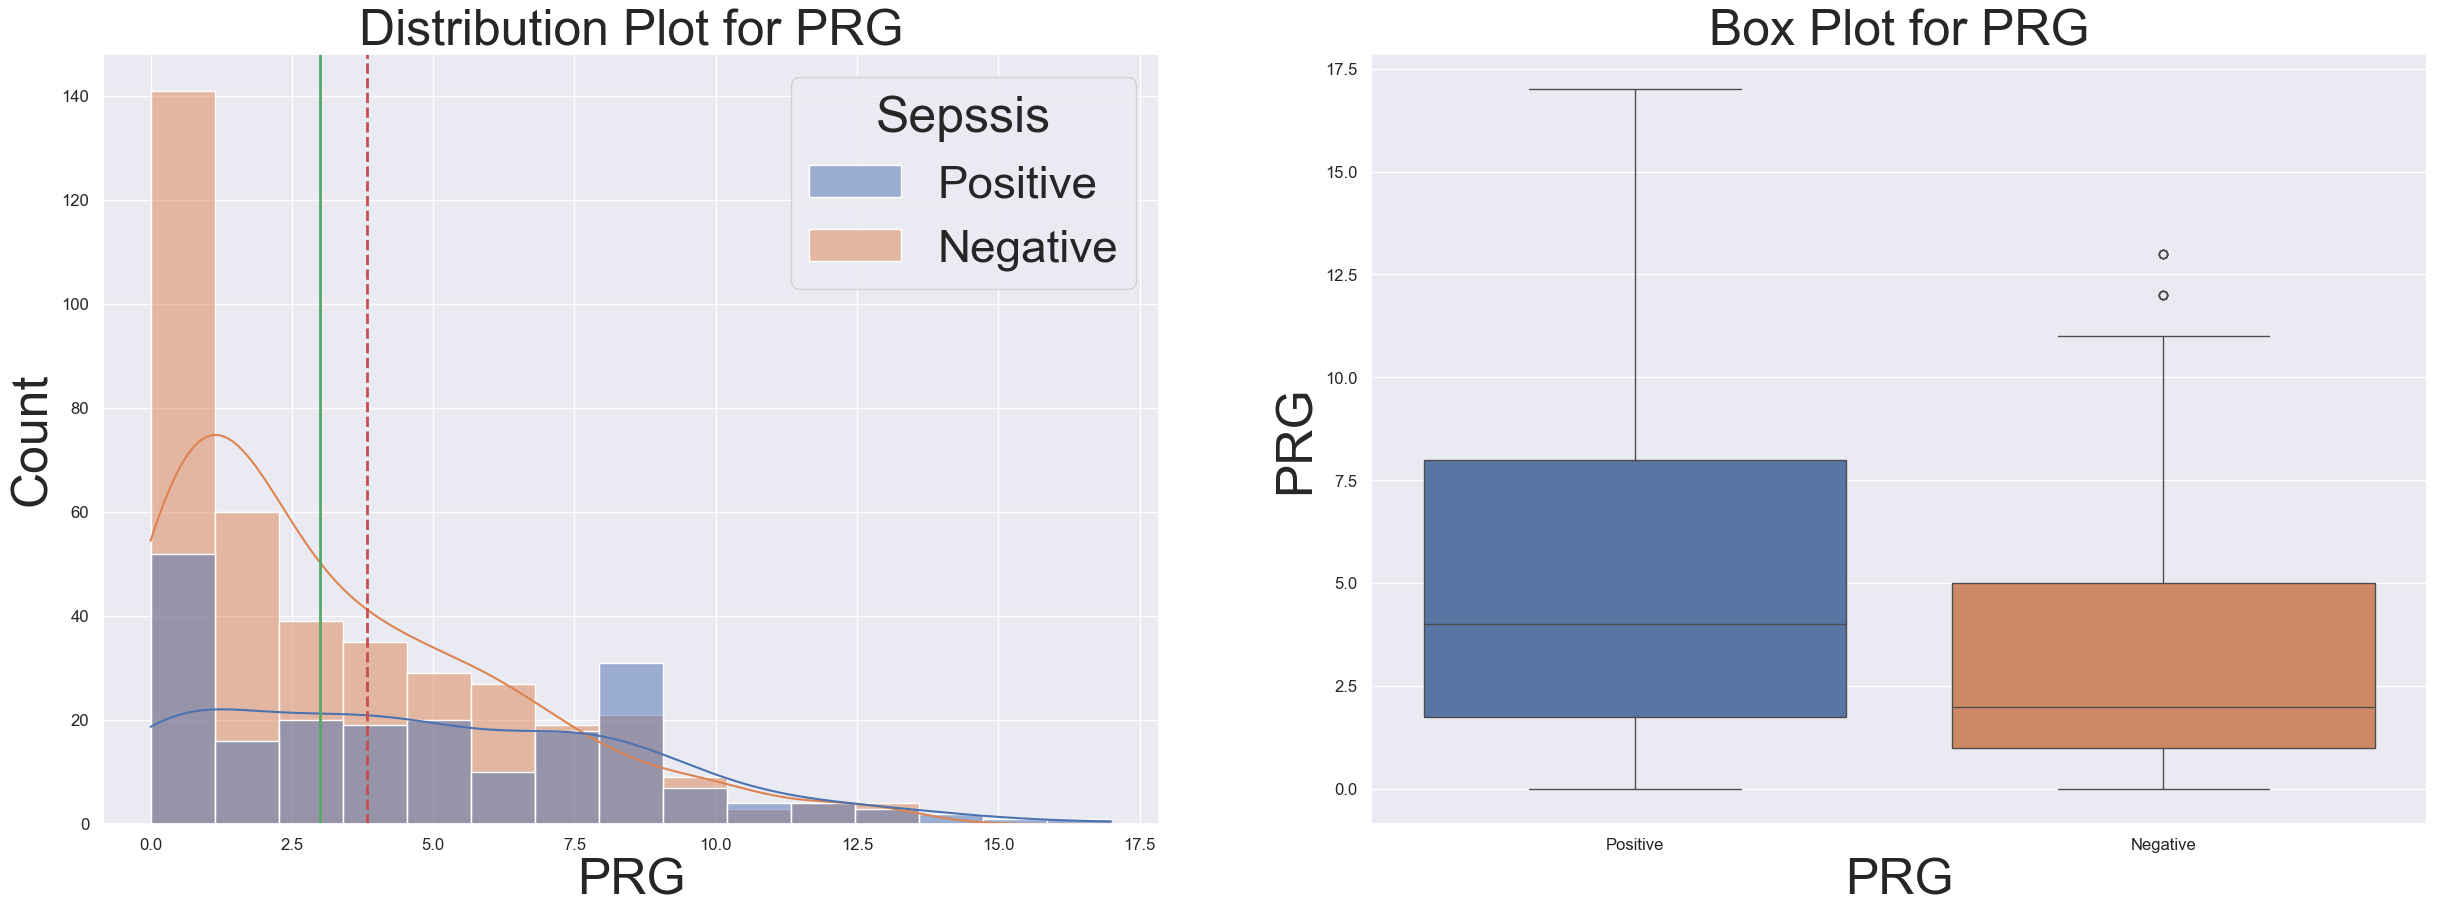

In [12]:
#plot distribution diagram and box plot for 'PRG'
plot_distribution_box('PRG')

#### Observation 2:
- `PRG` has a **right-skewed distribution**
- Patients with higher `PRG` have a higher chance to develop `Sepssis`. Especially those that have the figure that is more than 7.5, in which **positive rate accumulates more then negative**

#### 2.2.2. Blood Work Result-1 (PL)

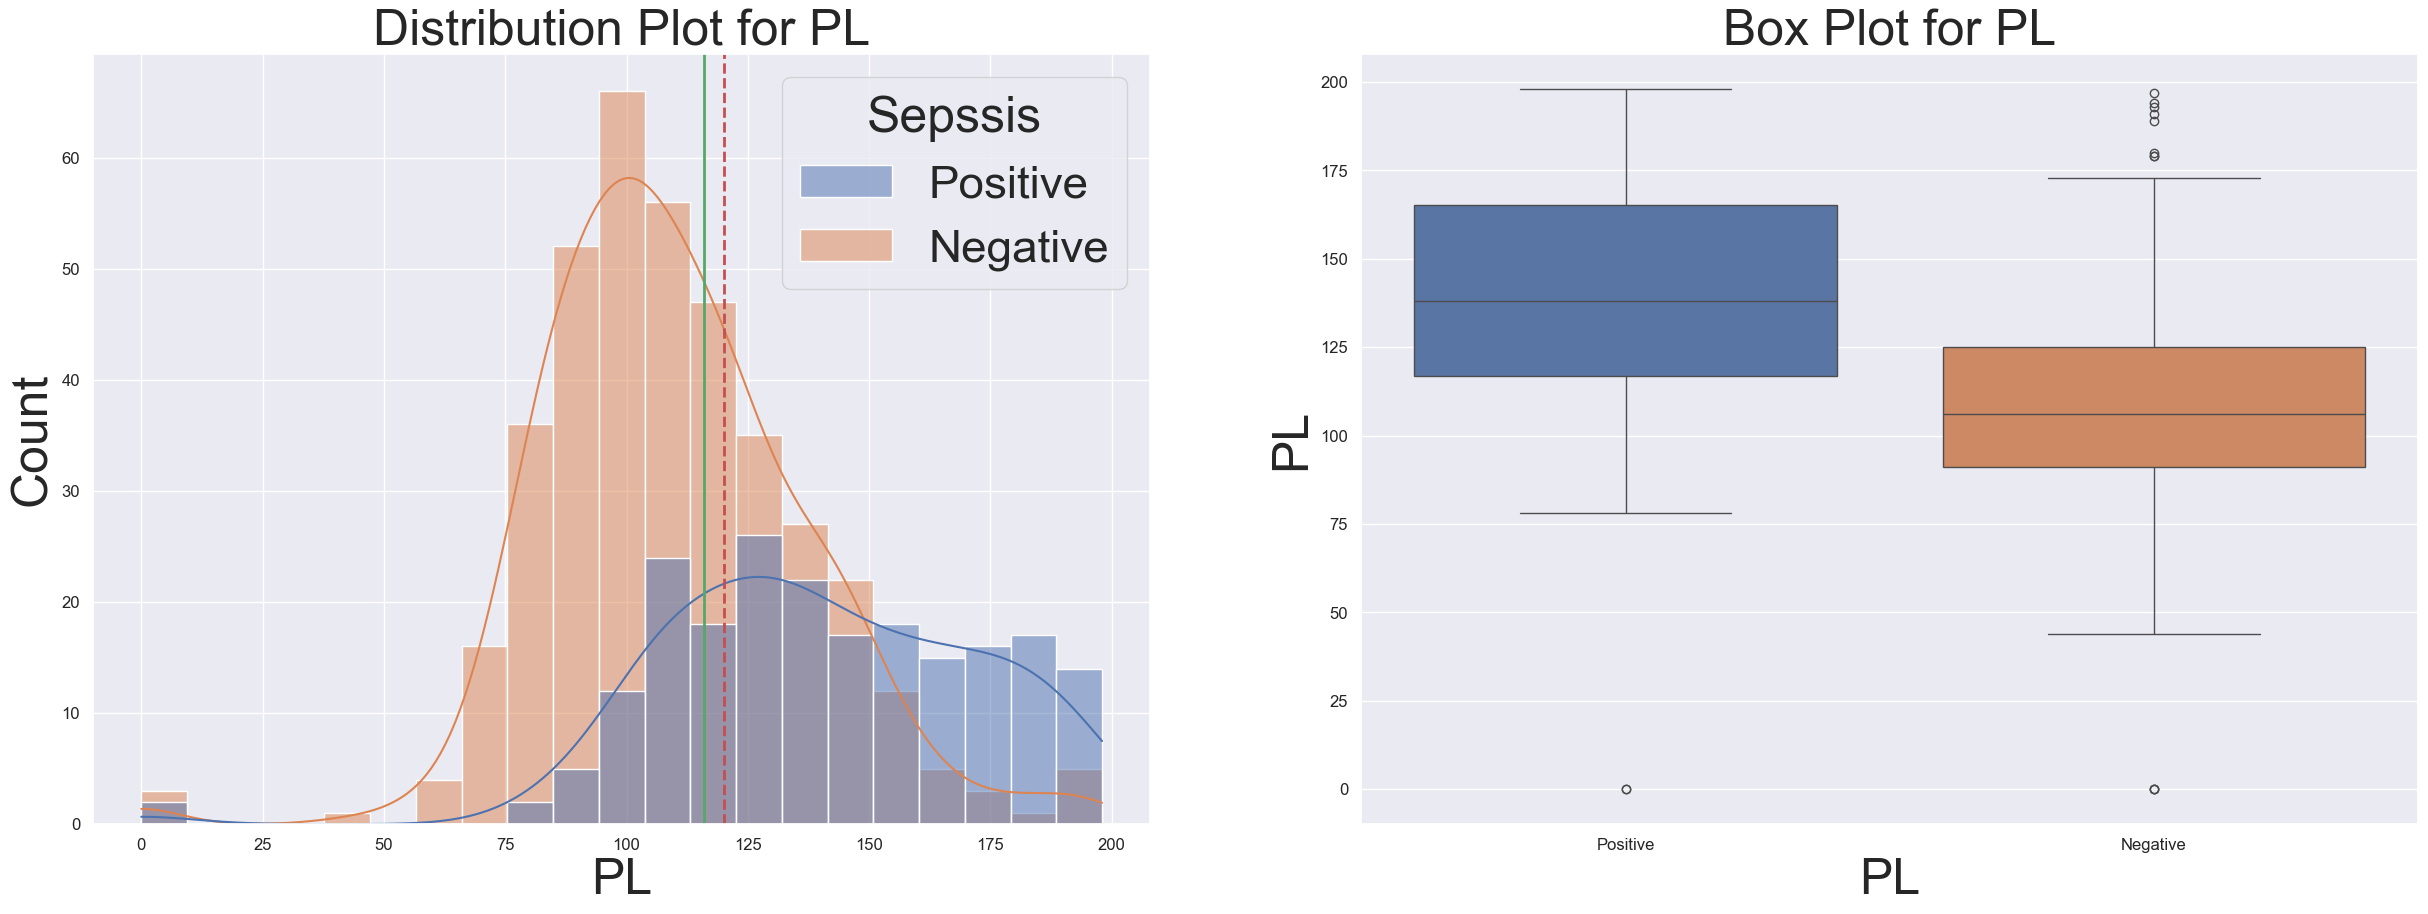

In [15]:
#plot distribution diagram and box plot for 'PL'
plot_distribution_box('PL')

#### Observation 3:
- `PL` has a **normal distribution**
- Patients with higher `PL` have a higher chance to develop `Sepssis`.
- Outliers detected at **0**

#### 2.2.3. Blood Pressure (PR)

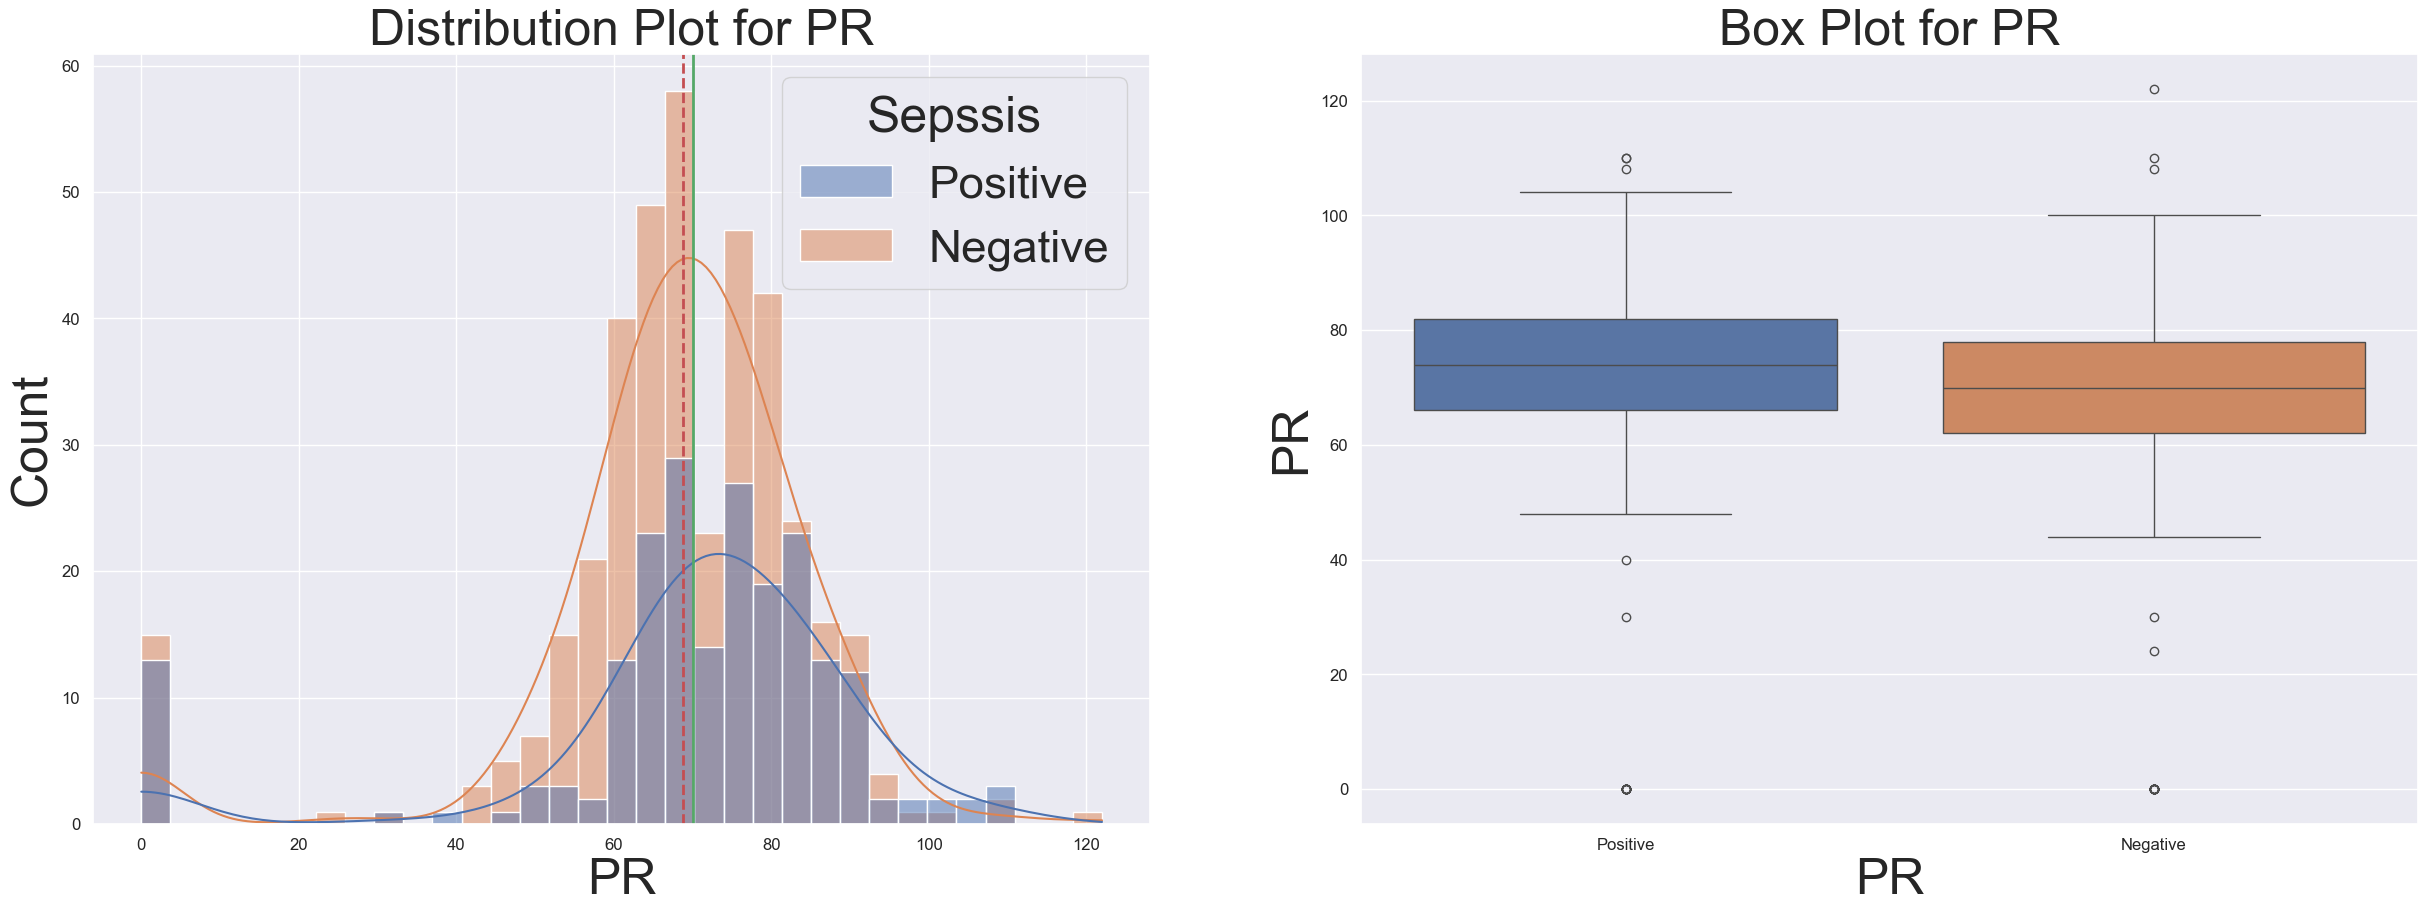

In [18]:
#plot distribution diagram and box plot for 'PR'
plot_distribution_box('PR')

#### Observation 4:
- `PR` has a **normal distribution**
- The distribution of `Sepssis` over `PR` are similar. There is no strong correlation between these two values.
- Outliers detected at **0**

#### 2.2.4. Blood Work Result-2 (SK)

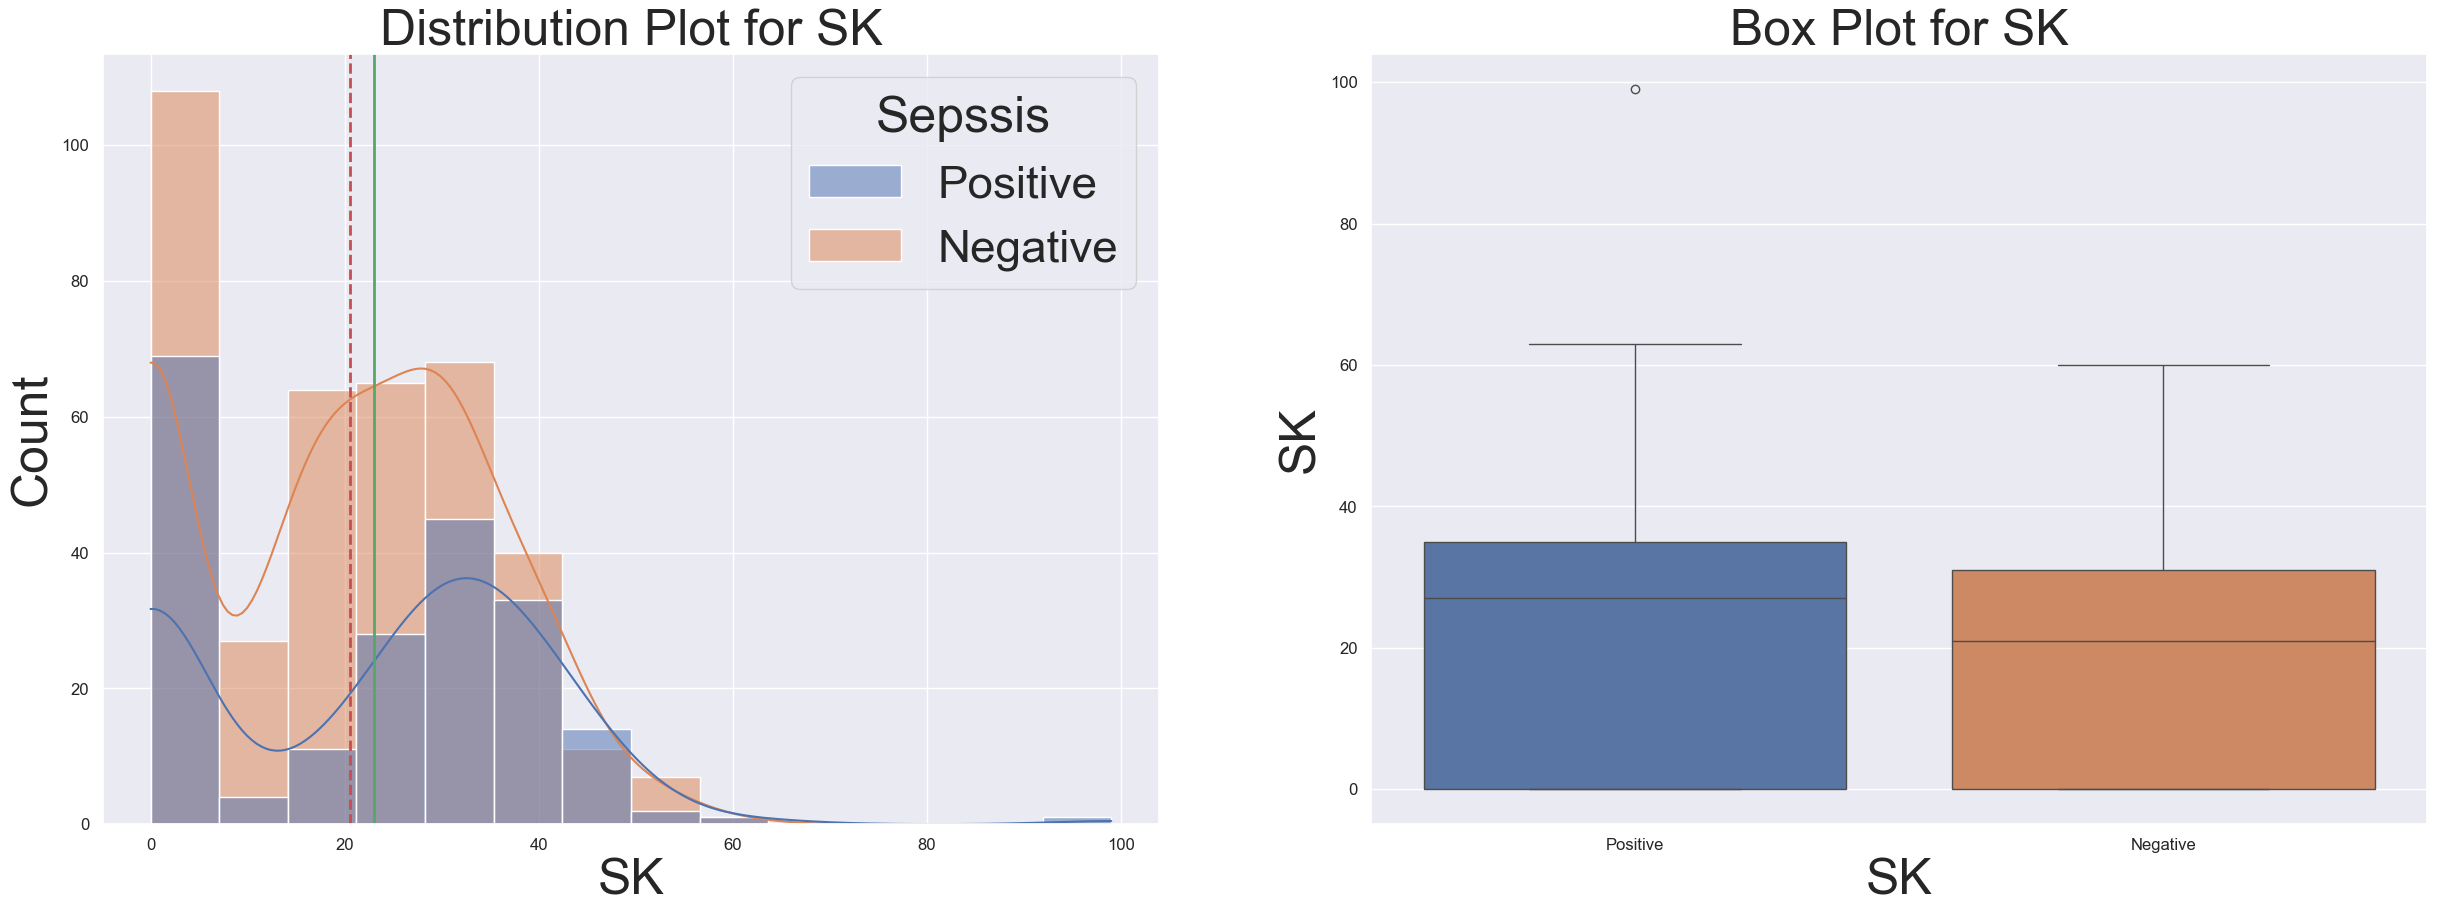

In [21]:
#plot distribution diagram and box plot for 'SK'
plot_distribution_box('SK')

#### Observation 5:
- `SK` has a **right-skewed distribution**
- The distribution of `Sepssis` over `SK` are similar. There is no strong correlation between these two values.
- Most of the values are at **0**

#### 2.2.5. Blood Work Result-3 (TS)

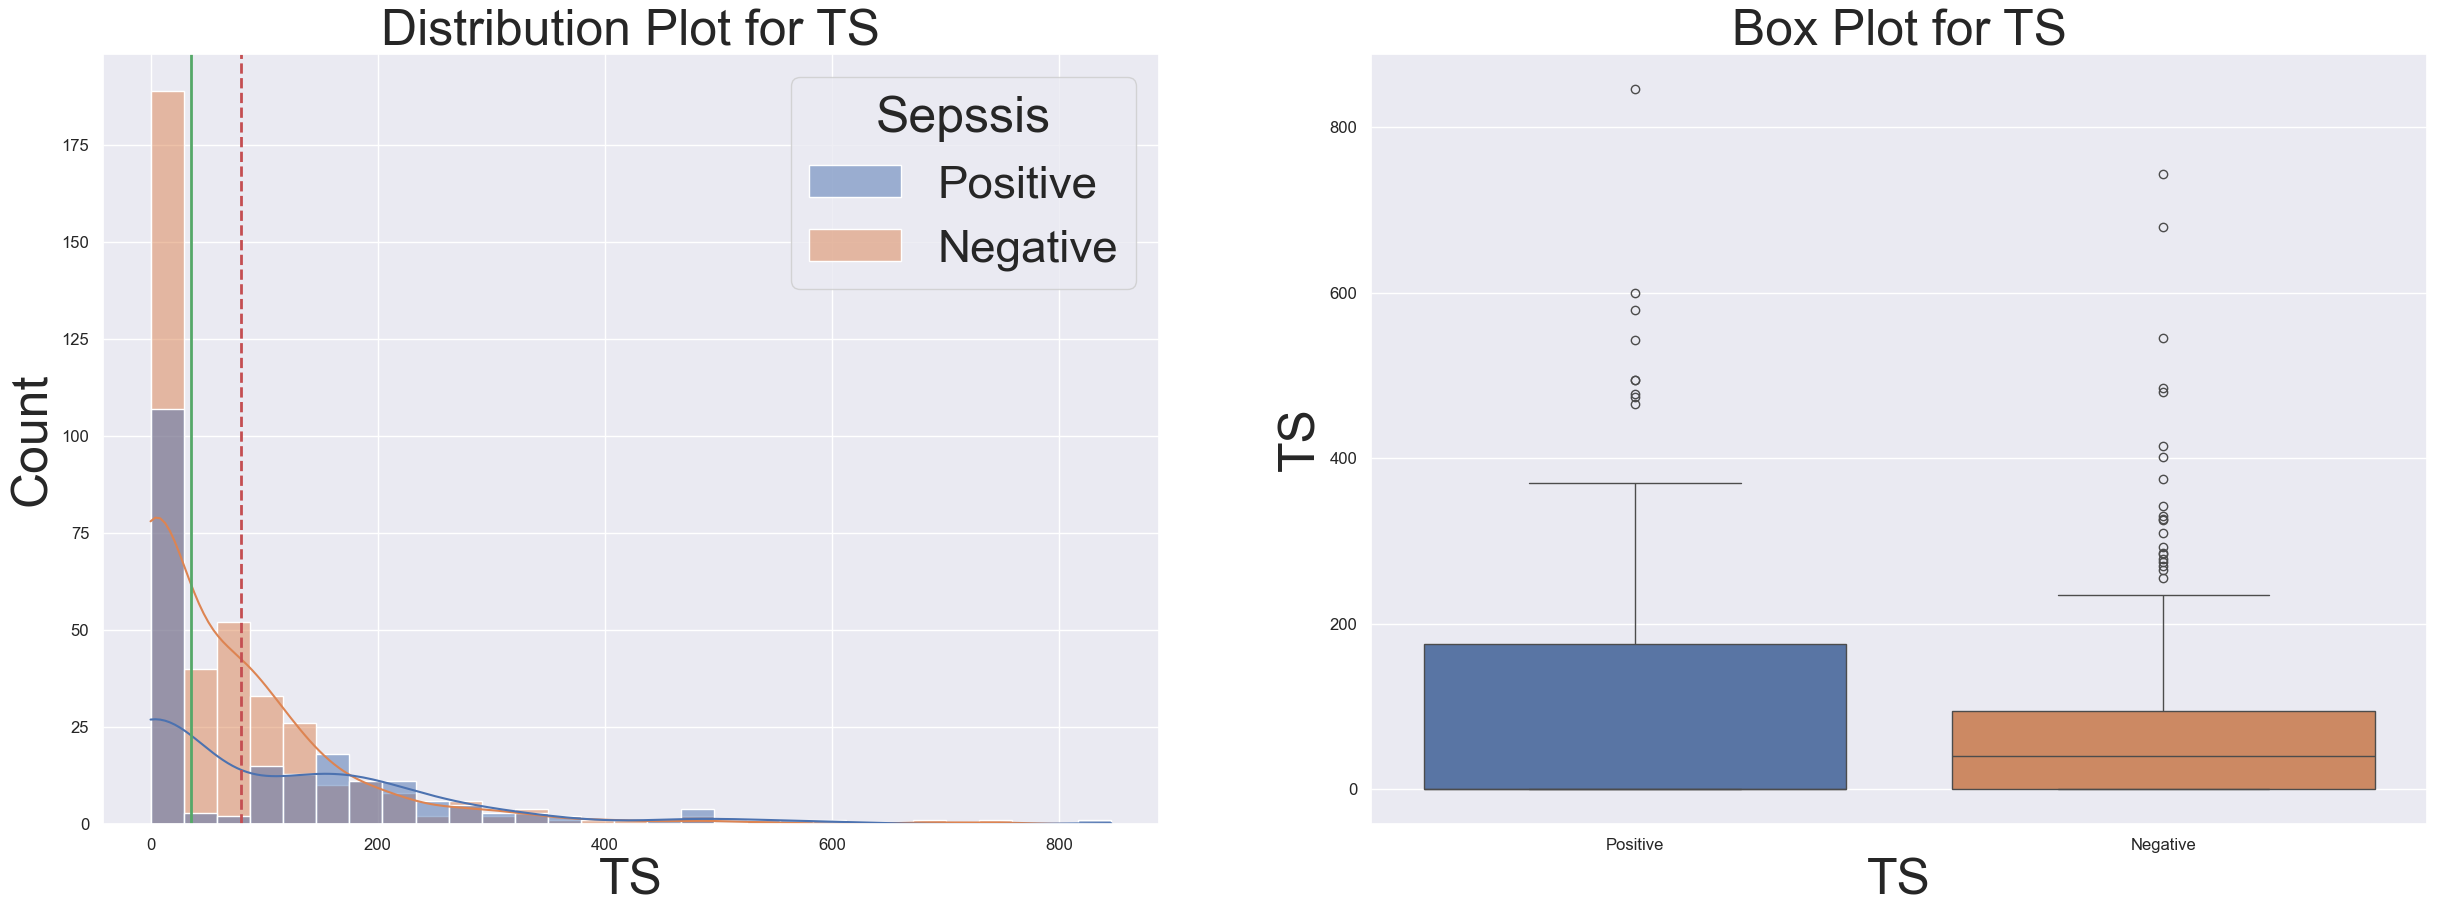

In [24]:
#plot distribution diagram and box plot for 'TS'
plot_distribution_box('TS')

#### Observation 6:
- `TS` has a **right-skewd distribution**
- Patients with higher `TS` have a higher rate to develop `Sepsiss` although there is not so many patients have high `TS` value.
- Outliers detected at **0**

#### 2.2.6. Body mass index (M11)

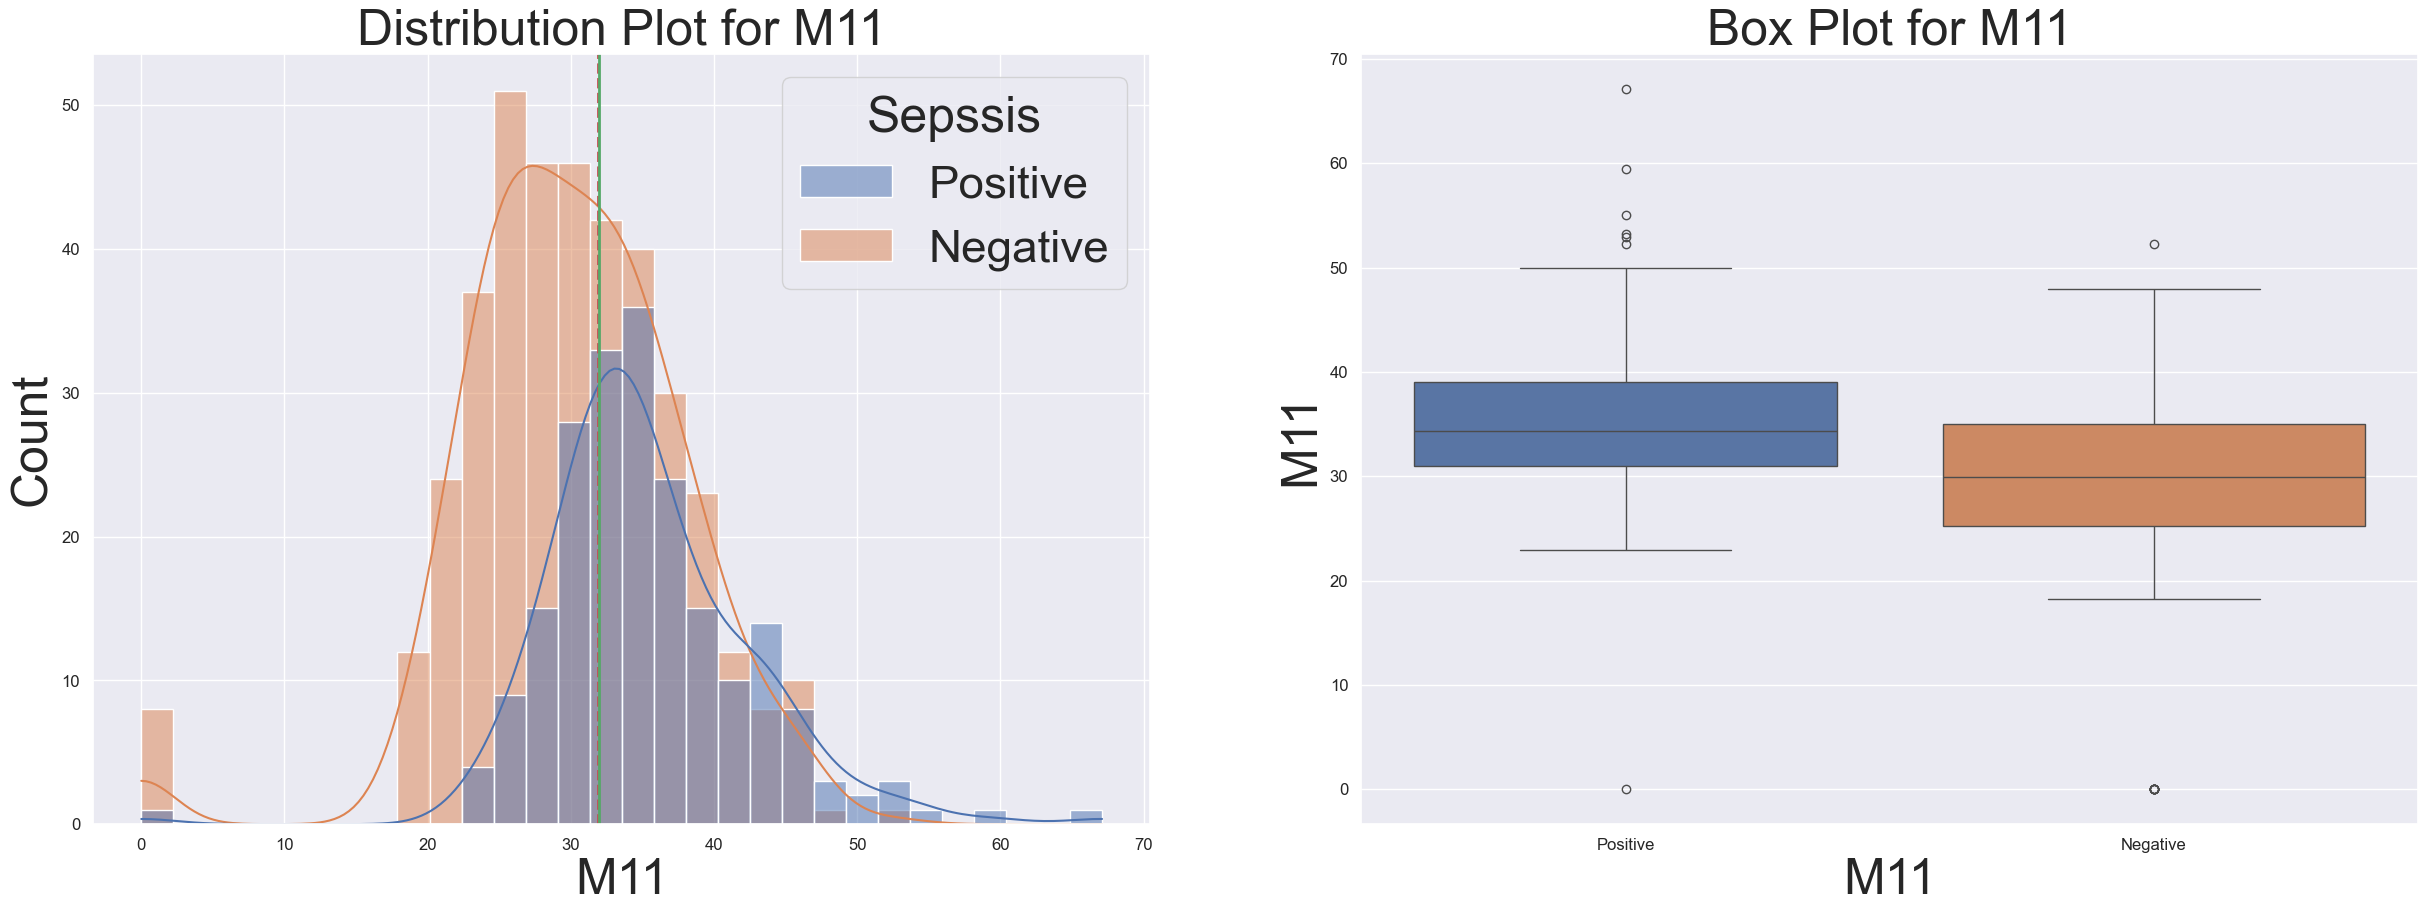

In [27]:
#plot distribution diagram and box plot for 'M11'
plot_distribution_box('M11')


#### Observation 7:
- `M11` has a **normal distribution**
- Patients with higher `M11` have a higher rate to develop `Sepsiss` although there is not so many patients have high `TS` value.
- Outliers detected at **0** as **Body mass index** can not equal to 0.
https://www.betterhealth.vic.gov.au/health/healthyliving/body-mass-index-bmi


#### 2.2.7. Blood Work Result-4 (BD2)

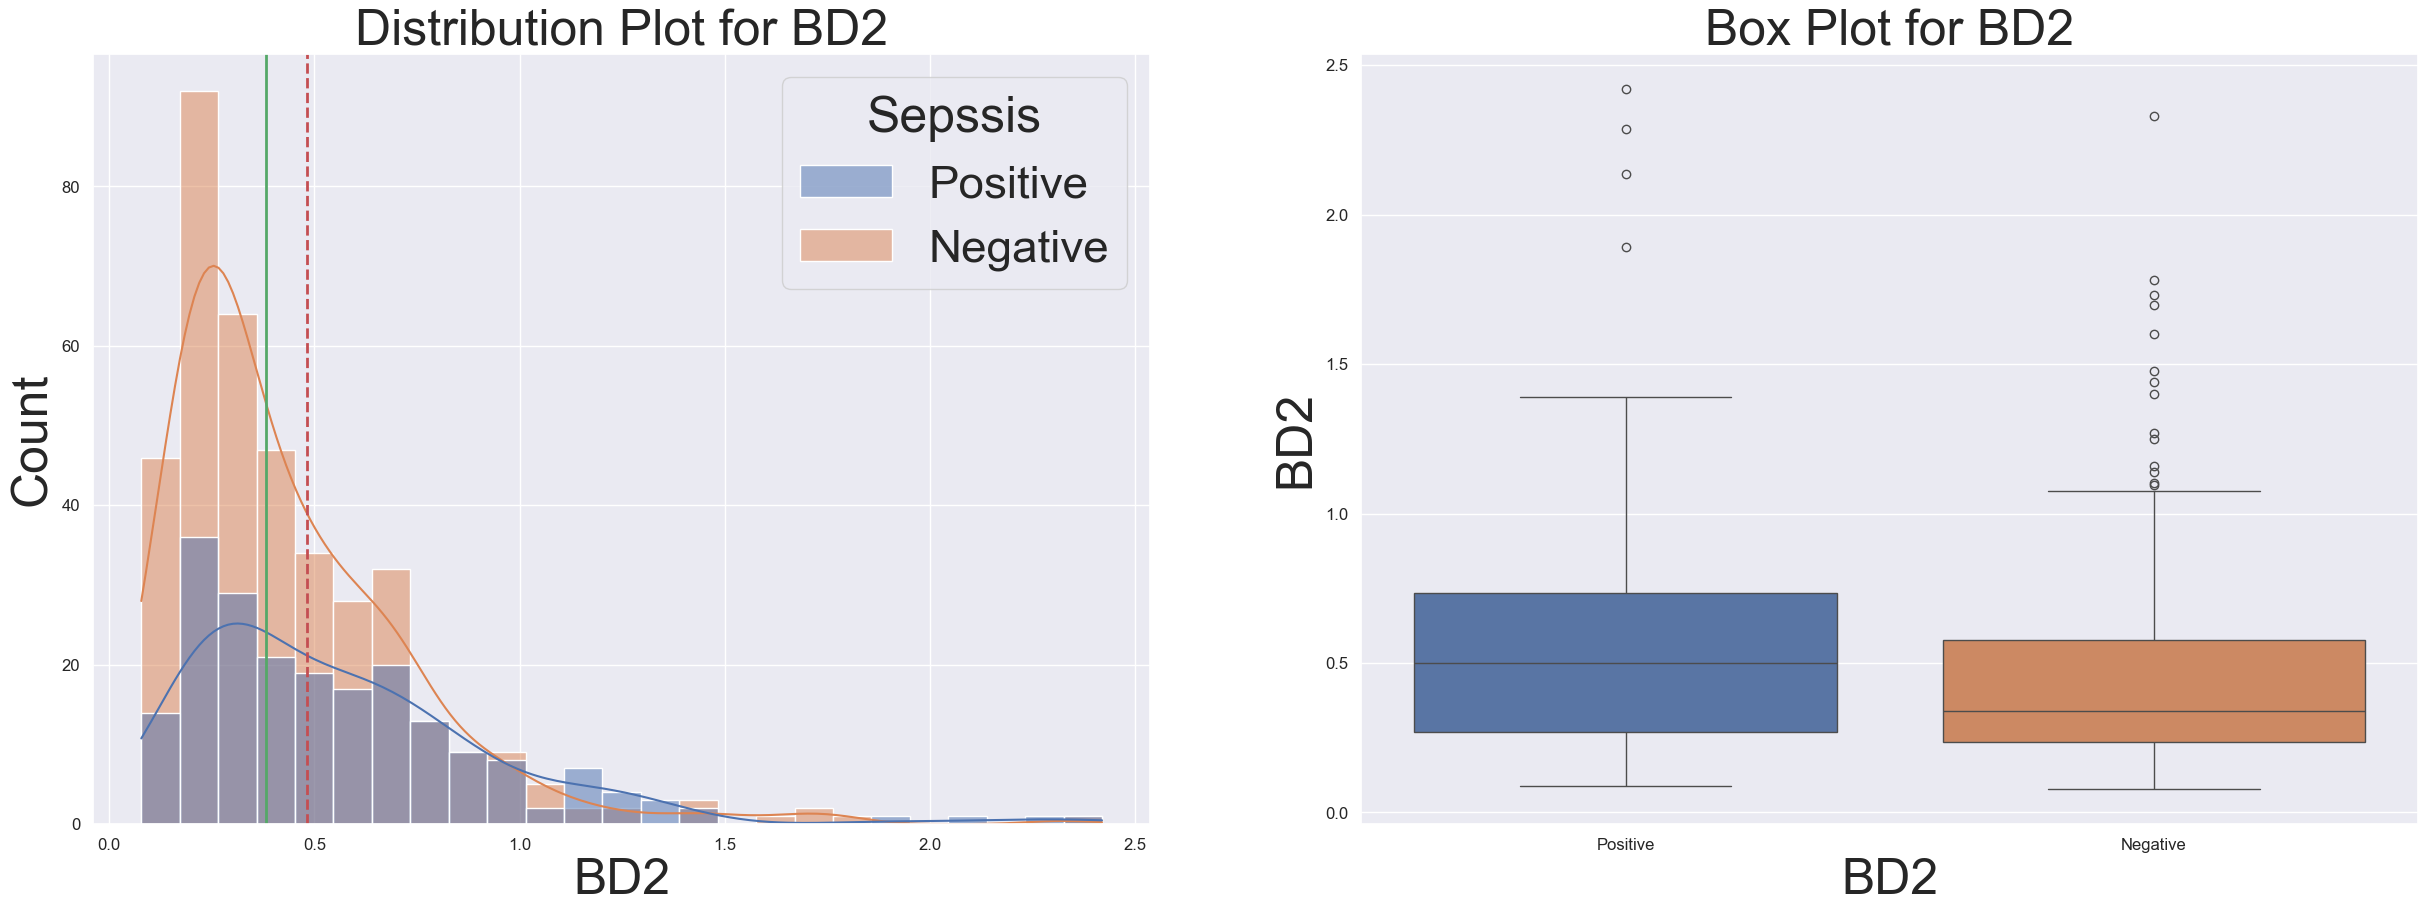

In [30]:
#plot distribution diagram and box plot for 'BD2'
plot_distribution_box('BD2')

#### Observation 8:
- `BD2` has a **right-skewd distribution**
- Patients with higher `BD2` have a higher rate to develop `Sepsiss` *(those have value that is higher than 0.5)*.
- Despite that, the correlation between these two variables is mild.

#### 2.2.8. Age

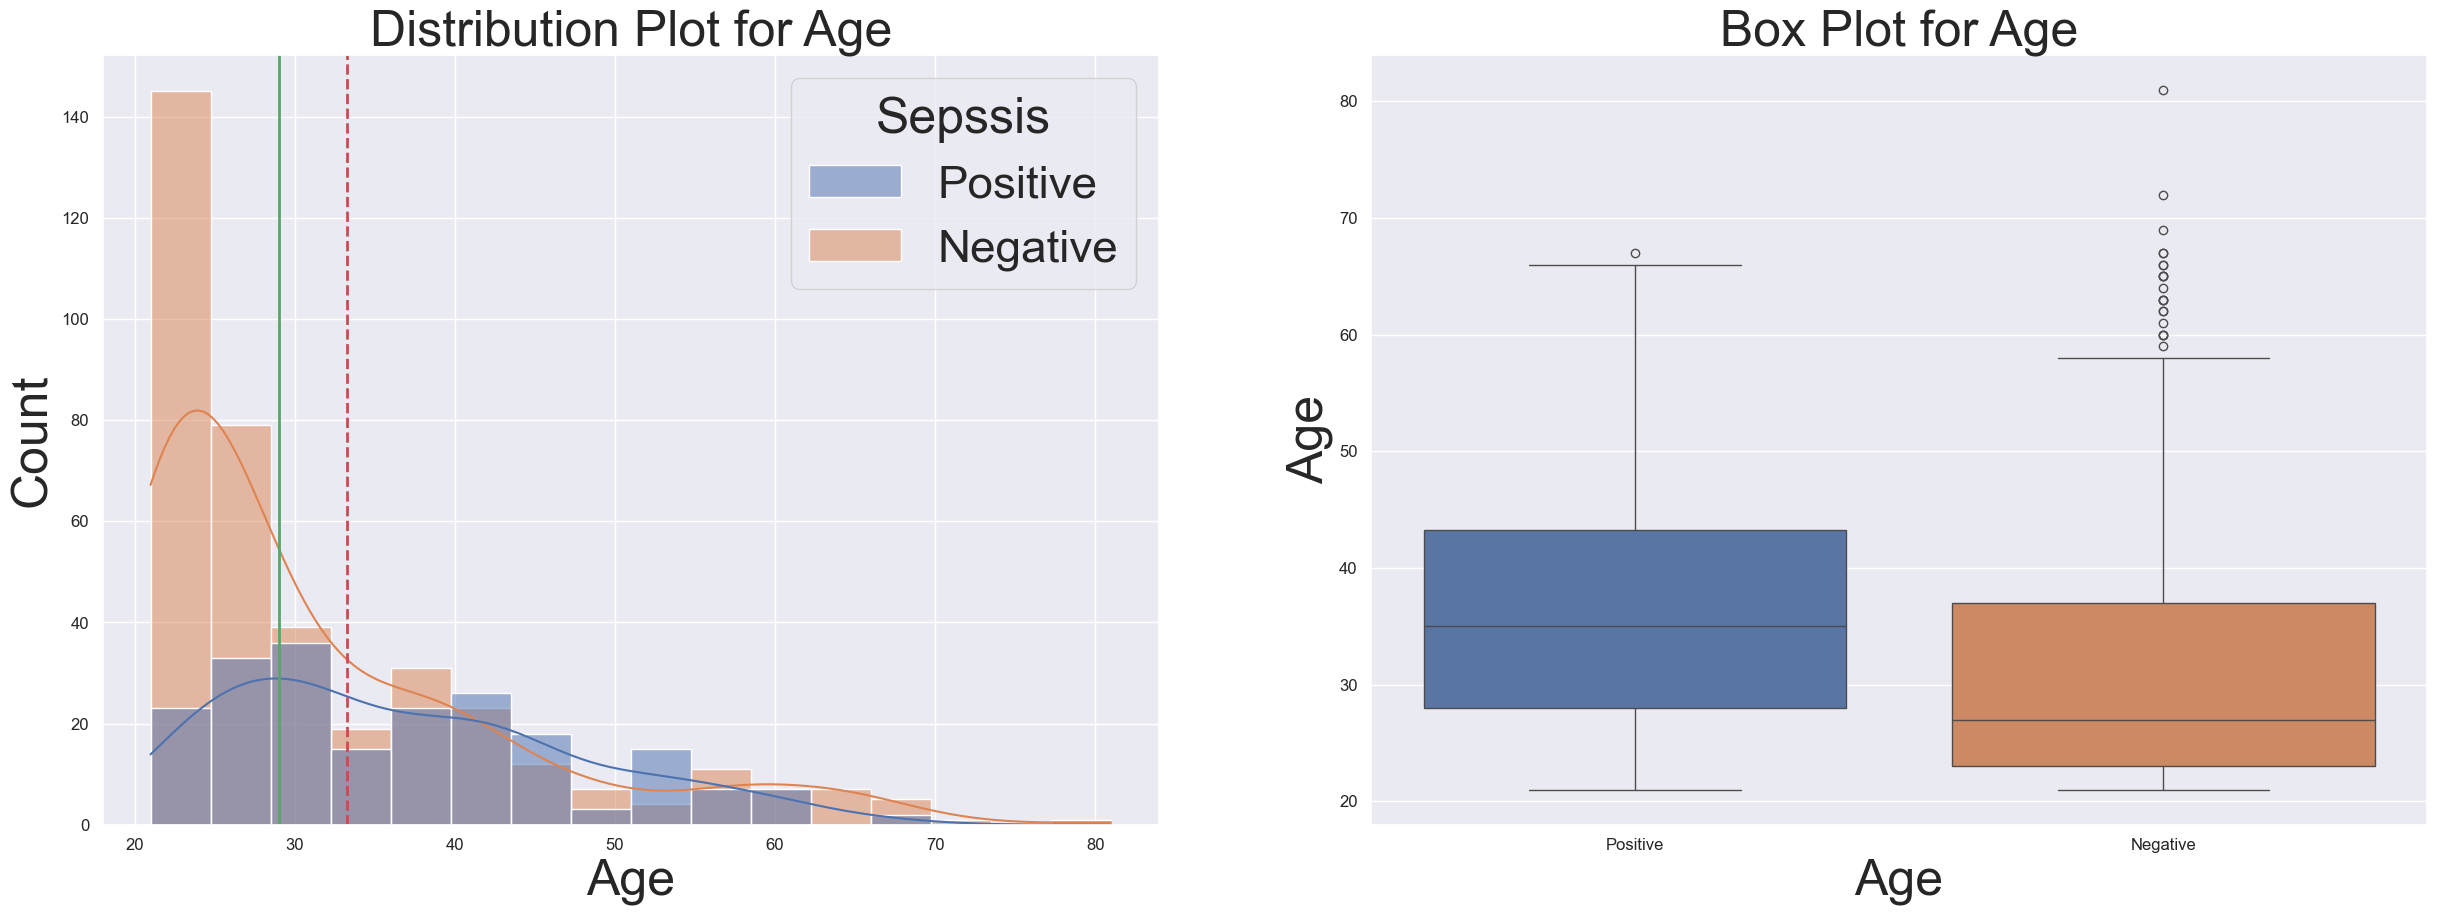

In [33]:
#plot distribution diagram and box plot for 'Age'
plot_distribution_box('Age')

#### Observation 9:
- `Age` has a **right-skewd distribution**, most of the recorded patients are in young age.
- Older patients have a higher rate to develop `Sepsiss`. Those are more than 30 years old has the similar rate between being positve and negative


### 2.3. Analysis of categorical variables

#### 2.3.1 Insurance

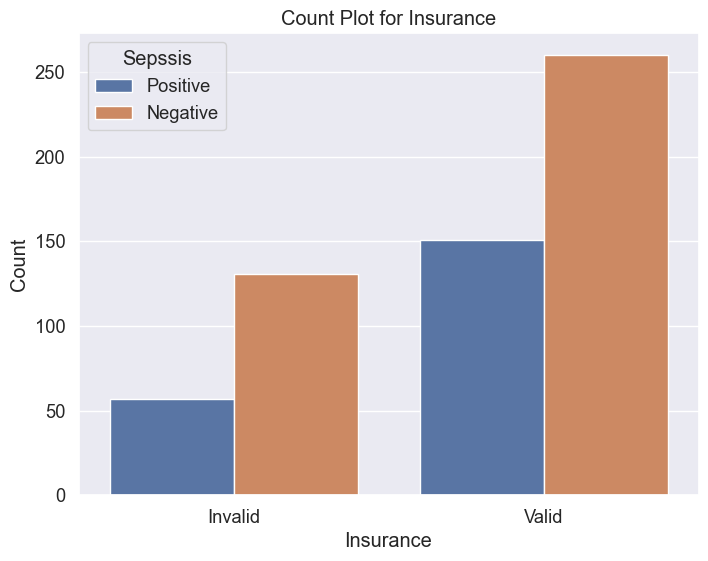

In [37]:
# Plot count plot for 'Insurance'
insurance_labels={0: 'Invalid', 1: 'Valid'}
custom_countplot('Insurance', x_ticklabels=insurance_labels)

#### Observation 10:
- There are a significant amount of patients that have *invalid* insurance, accumulating a third of the entries.
- The validity of the insurance do not have major effect on the development of `Sepssis` as the rate of hitting positive in either categories are similar.

### 2.4. Analysis of Sepssis

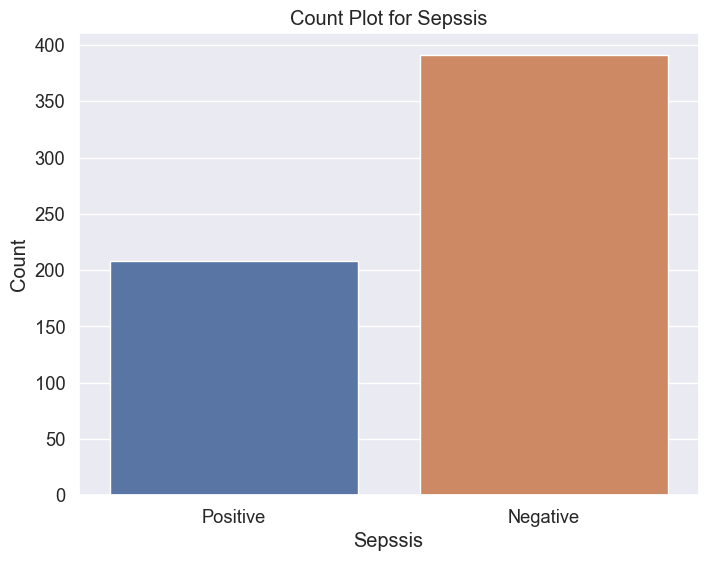

In [40]:
# Plot count plot for 'Sepssis'
custom_countplot('Sepssis')

#### Observation 11:
- The dataset has a majority of negative results of `Sepssis`.
  
=> **the data is imbalanced**, this should be taken into consideration when training the models.

### 2.5. Variables Correlation

As `Sepssis` is categorical and has literal value => **Binary transformation** is needed

In [44]:
seps={'Negative':0, 'Positive': 1}
patients_df['Sepssis'] = patients_df['Sepssis'].map(seps)
patients_df.head()

ID  PRG   PL  PR  SK   TS   M11    BD2  Age  Insurance  Sepssis
0  ICU200010    6  148  72  35    0  33.6  0.627   50          0        1
1  ICU200011    1   85  66  29    0  26.6  0.351   31          0        0
2  ICU200012    8  183  64   0    0  23.3  0.672   32          1        1
3  ICU200013    1   89  66  23   94  28.1  0.167   21          1        0
4  ICU200014    0  137  40  35  168  43.1  2.288   33          1        1

Column `ID` is unnecesary here. 

In [46]:
patients_df = patients_df.drop(columns=['ID'])

Text(0.5, 1.0, 'Correlation Matrix of Data')

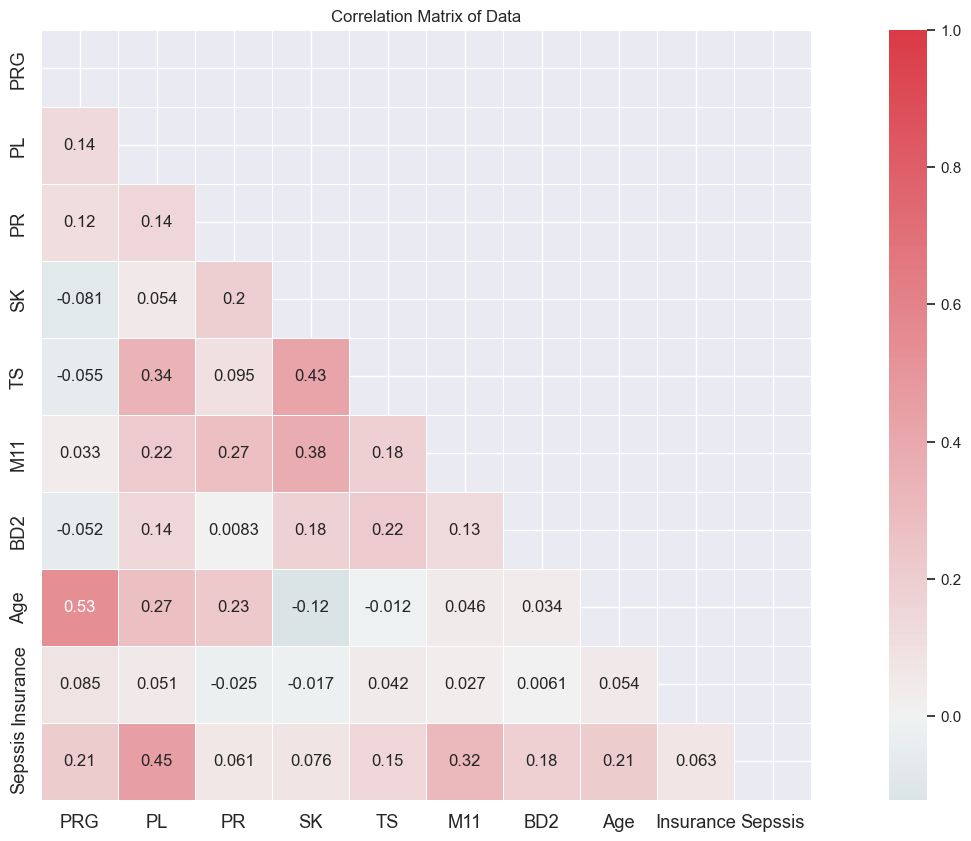

In [47]:
corr = patients_df.corr()

# mask for better visualization
mask = np.zeros_like(corr, dtype = bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (20, 10))

# color
cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.set(font_scale=1)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": 1}, annot = True)

ax.set_title('Correlation Matrix of Data')

- Through this overall heatmap, the above assumptions are strengthen as PL has the highest correlation, M11 in the second place, Age and PRG comes next. These features will be meaningful for our model.


## 3. DATA PROCESSING
- With the EDA process output, the dataframe that is put into model will have selective features, so that the model will be less resources‐consuming, more efficient regarding accuracy and more comprehendable. 
- In this case, `PL`,`M11`, `Age` and `PRG` are kept.

In [50]:
patients_df.drop(columns = ["PR", "SK", "Insurance"], inplace=True) 

### 3.1. Split train-test set

In [52]:
train_set, test_set = train_test_split(patients_df, test_size=0.2, random_state=42, stratify=patients_df['Sepssis'])
print('\n____________ Split training and test set ____________')     
print(len(train_set), "training +", len(test_set), "test examples")
print(train_set.head(4))


____________ Split training and test set ____________
479 training + 120 test examples
     PRG   PL   TS   M11    BD2  Age  Sepssis
161    7  102  105  37.2  0.204   45        0
236    7  181  192  35.9  0.586   51        1
497    2   81   76  30.1  0.547   25        0
40     3  180   70  34.0  0.271   26        0


In [53]:
y_train = train_set["Sepssis"].copy()
X_train = train_set.drop(columns = "Sepssis") 
y_test= test_set["Sepssis"].copy()
X_test = test_set.drop(columns = "Sepssis") 

### 3.2. Data Processing


#### 3.2.1. Processing Pipeline
- As analysed above, `PL` and `M11` have outliers at 0 *(Observation and Observation 7)*. These outliers are imputed with the median of the corresponding features. Median is used since `PL` values are in *integer* and also the median and mean of `M11` are approximately the same.
- **MinMaxscaler** is used to apply normalization as many features are skewed. This approach remains the original distribution of the data.

In [56]:
# transformer that handles outliers of 'PL' and 'M11'
outliers_transformer = ColumnTransformer(transformers=[
        ("outliers_handlers", SimpleImputer(missing_values=0, strategy="median", copy=True), ['PL', 'M11'])
], remainder='passthrough')

# preprocessor pipeline
preprocessor_pipeline = Pipeline([
    ('outliers_handlers', outliers_transformer),
    ('scaler', StandardScaler())
    #('scaler', MinMaxScaler())
])

preprocessor_steps = [
    ('outliers_handlers', outliers_transformer),
    ('scaler', MinMaxScaler())
]

#### 3.2.2. Synthetic Minority Oversampling Technique (SMOTE)
- The imbalance of the target class *(Observation 11)* might results in a biased model which performs better over **negative** examples and worse over **positive**
- To avoid this, the dataset should be balanced and SMOTE is applied to resample the train set that generates more examples of minority calss (**positive**)

In [58]:
sm = SMOTE()
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Before oversampling
unique, counts = np.unique(y_train, return_counts = True)
print(np.asarray((unique, counts)).T)

# After oversampling
unique, counts = np.unique(y_train_res, return_counts = True)
print(np.asarray((unique, counts)).T)

[[  0 313]
 [  1 166]]
[[  0 313]
 [  1 313]]


#### 3.2.2. Polynomial (Feature Engineering)

In [60]:
# polynomial preprocessor pipeline
poly_feat_adder = PolynomialFeatures(degree = 2) # add high-degree features to the data

poly_preprocessor_steps = preprocessor_steps + [('polynomial', poly_feat_adder)]

poly_preprocessor_pipeline = Pipeline(poly_preprocessor_steps)

## 4. TRAINING MODELS

### 4.1. Models training utilities

In [63]:
def train_and_report(model,  X_train, y_train, X_test, y_test, model_name="", grid=False):
    
    '''
    Purpose: 
        Generate the consolidated test classification report. 
        The report consists of the following classification results & metrics -
            1. Confusion Matrix
            2. Classification Report
            3. F1 Score
            4. Accuracy
            5. Mathews Correlation Coefficient (MCC)
            6. Precision
            7. Recall
            8. AUROC Score - Area Under the Receiver Operating Characteristic Curve
            10. AUROC Curve - Area Under the Receiver Operating Characteristic Curve

    Return Value: 
       trained model
    '''
    # Train the model
    model.fit(X_train, y_train)

    # Predict test set using the model
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1:]

    if grid == True:
        print(f'Best params for the model: {model.best_params_}')
    
    

    ##########

    # REPORT SECTION 
    # Report Title
    fig, axes = plt.subplots(2, 1, figsize = (8, 3))
    axes[0].text(9, 1.8, "Model Report", fontsize=30, horizontalalignment='center', 
                 color='DarkBlue', weight = 'bold')

    axes[0].axis([0, 10, 0, 10])
    axes[0].axis('off')

    axes[1].text(9, 4, "Model Name: " + model_name, style='italic', 
                         fontsize=18, horizontalalignment='center', color='DarkOrange', weight = 'bold')

    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')

    ##########
    
    # Calculate ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test.values.ravel(), y_pred)

    # Calculate the individual classification metric scores
    scores = []
    metrics = ['F1       ', 'MCC      ', 'Precision', 'Recall   ', 'Accuracy ',
               'AUC_ROC  ']
    
    model_f1_score = f1_score(y_test, y_pred)
    model_matthews_corrcoef_score = matthews_corrcoef(y_test, y_pred)
    model_precision_score = precision_score(y_test, y_pred)
    model_recall_score = recall_score(y_test, y_pred)
    model_accuracy_score = accuracy_score(y_test, y_pred)
    model_auc_roc = auc(fpr, tpr)

    scores.append([model_f1_score,
                   model_matthews_corrcoef_score,
                   model_precision_score,
                   model_recall_score,
                   model_accuracy_score,
                   model_auc_roc])

    ##########
    
    # Confusion Matrix
    conf_matx = confusion_matrix(y_test, y_pred)
    # display Confusion Matrix
    fig, axes = plt.subplots(1, 3, figsize = (20, 4))
    sns.heatmap(conf_matx, annot=True, annot_kws={"size": 16},fmt='g', cbar=False, cmap="GnBu", ax=axes[0])
    axes[0].set_title("1. Confusion Matrix", fontsize=21, color='darkgreen', weight = 'bold', 
                      style='italic', loc='left')

    ##########
    
    # Classification Metrics
    sampling_results = pd.DataFrame(columns = ['Classification Metric', 'Score Value'])
    for i in range(len(scores[0])):
        sampling_results.loc[i] = [metrics[i], scores[0][i]]

    sampling_results.index = np.arange(1, len(sampling_results) + 1)
    
    # display Classification Metrics
    axes[1].text(5, 1.8, sampling_results.to_string(float_format='{:,.4f}'.format, index=False), style='italic', 
                 fontsize=20, horizontalalignment='center')
    axes[1].axis([0, 10, 0, 10])
    axes[1].axis('off')
    axes[1].set_title("2. Classification Metrics", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center')

    ##########
    
    # Classification Report
    class_report = classification_report(y_test, y_pred)
    # display Classification Report
    axes[2].text(0, 1, class_report, style='italic', fontsize=20)
    axes[2].axis([0, 10, 0, 10])
    axes[2].axis('off')
    axes[2].set_title("3. Classification Report", fontsize=20, color='darkgreen', weight = 'bold', 
                      style='italic', loc='center')
    plt.tight_layout()
    plt.show()
    
    ##########

    # AUC-ROC Curve
    model_roc_auc = roc_auc_score(y_test, y_pred)
    plt.figure(figsize = (12.8 , 6))
    plt.plot(fpr, tpr, label = 'AUC = {})'.\
             format(model_roc_auc.round(4)))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc = 'lower right')
    plt.show()
    

### 4.2. Model 1: Logistic Regression

#### 4.2.1. Logistic Regression

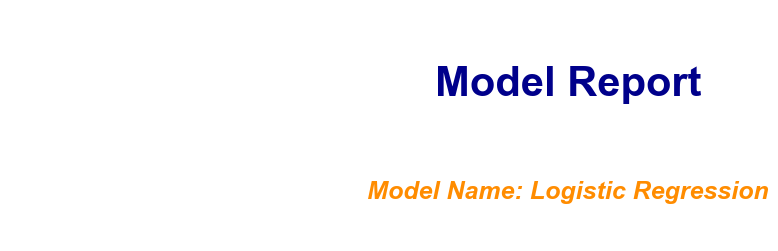

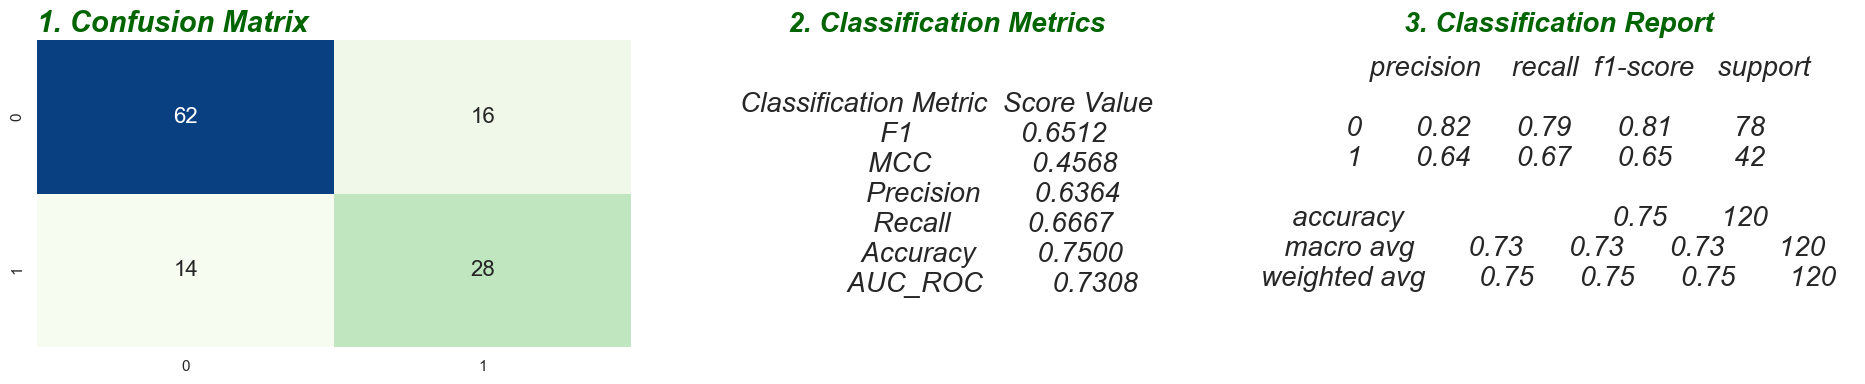

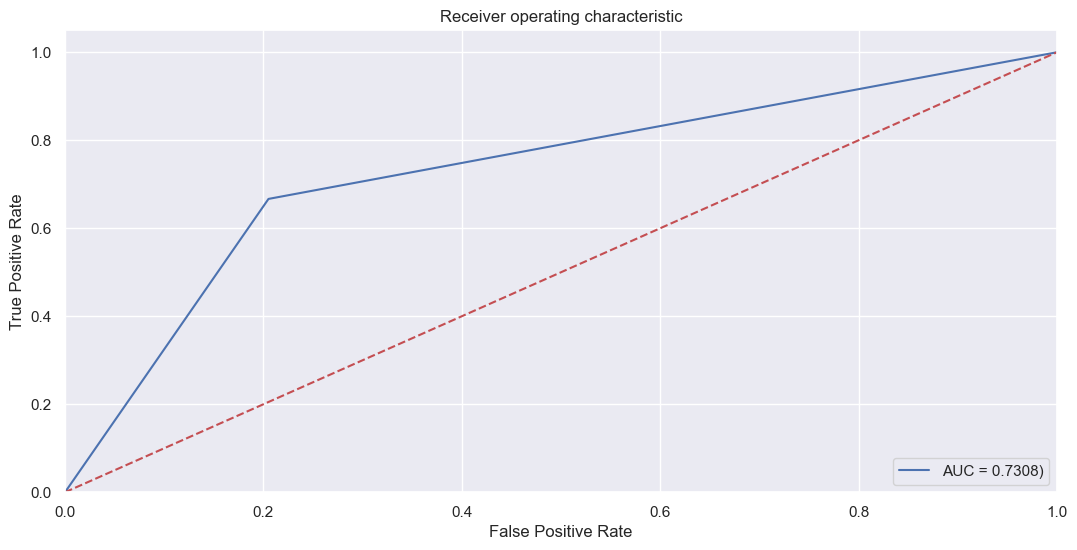

In [66]:
lr_clf = LogisticRegression()

lr_clf = train_and_report(lr_clf, X_train, y_train, X_test, y_test, "Logistic Regression")

#### 4.2.2. Logistic Regression with Transformed Data

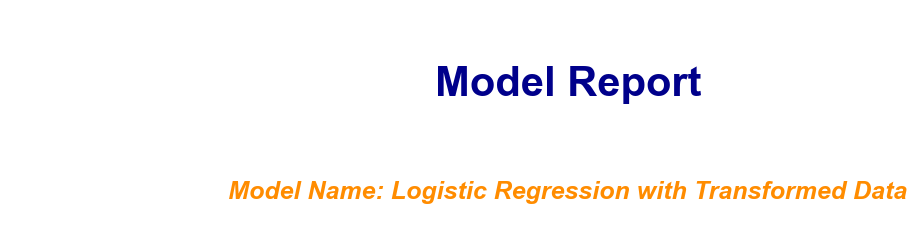

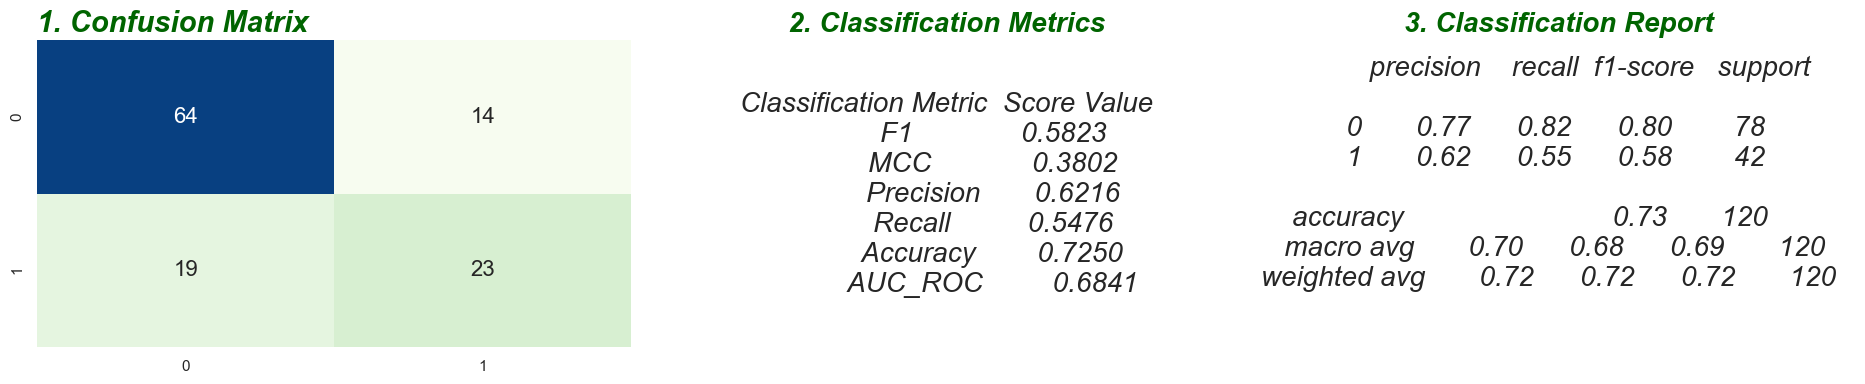

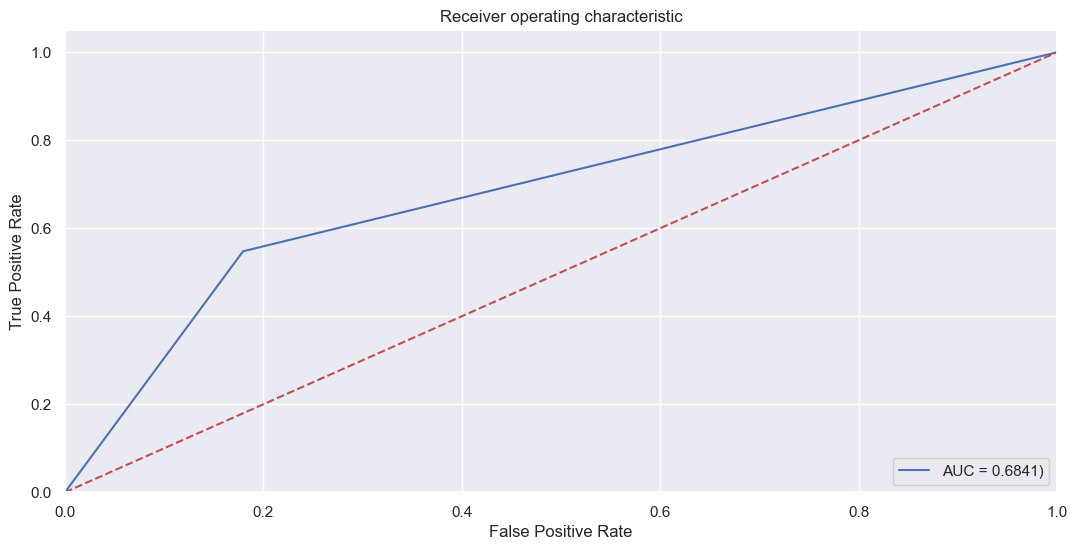

In [68]:
lr_steps = preprocessor_steps + [('lr', LogisticRegression())]
lr_clf = Pipeline(lr_steps)

lr_clf = train_and_report(lr_clf, X_train, y_train, X_test, y_test, "Logistic Regression with Transformed Data")

#### 4.2.3. SMOTE Logistic Regression

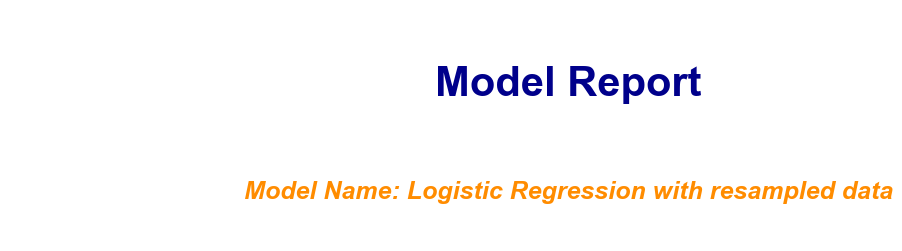

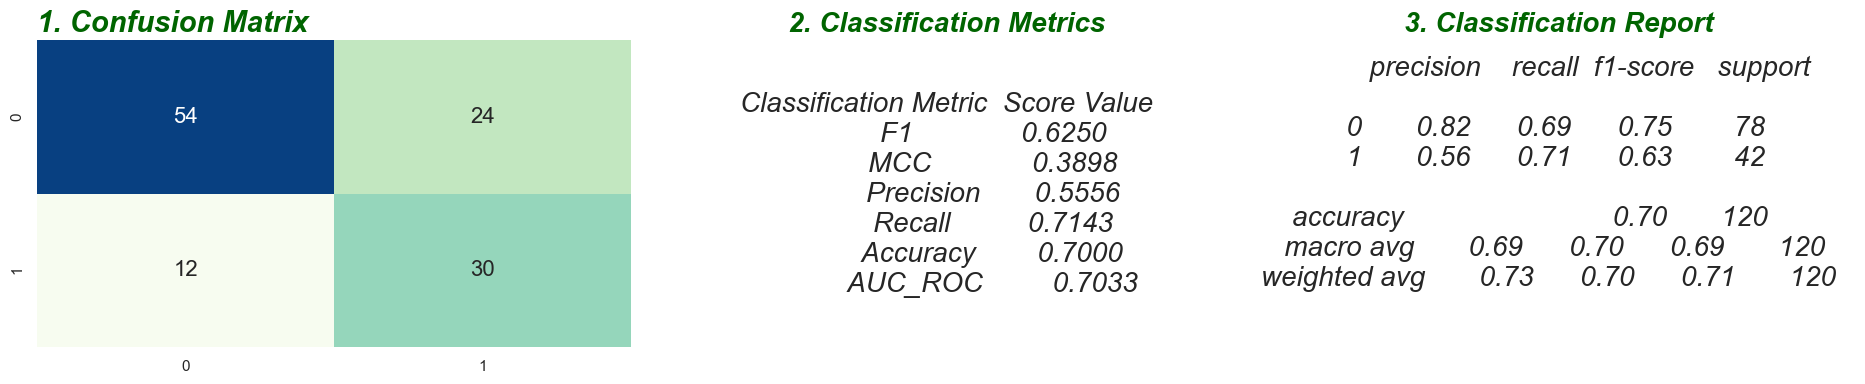

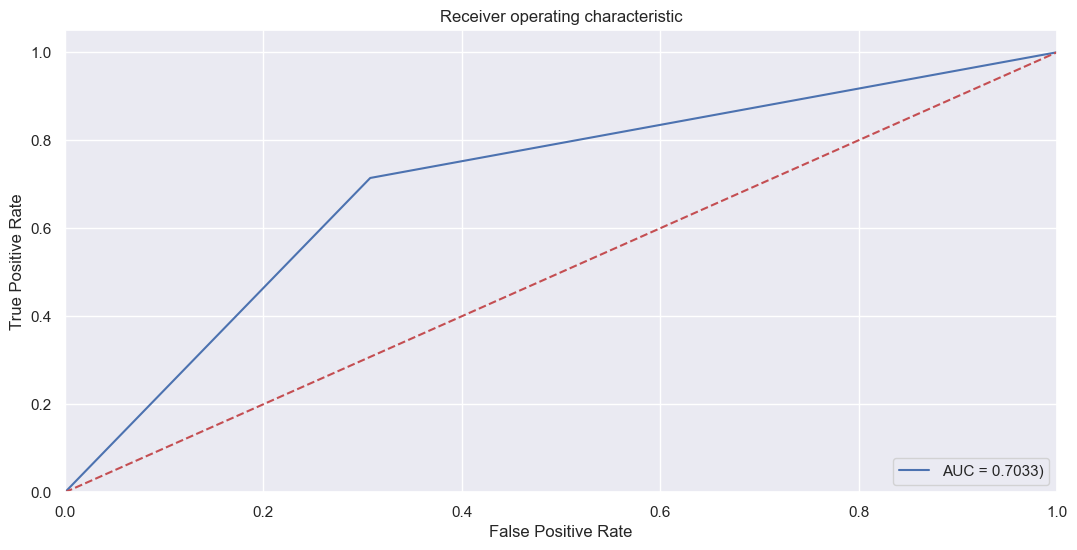

In [70]:
lr_sm_steps = preprocessor_steps + [('lr', LogisticRegression())]
lr_sm_clf = Pipeline(lr_steps)

lr_sm_clf = train_and_report(LogisticRegression(), X_train_res, y_train_res, X_test, y_test, "Logistic Regression with resampled data")

#### 4.2.4. Polynomial Logistic Regression

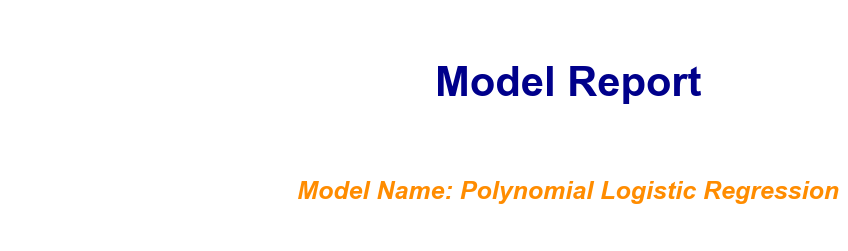

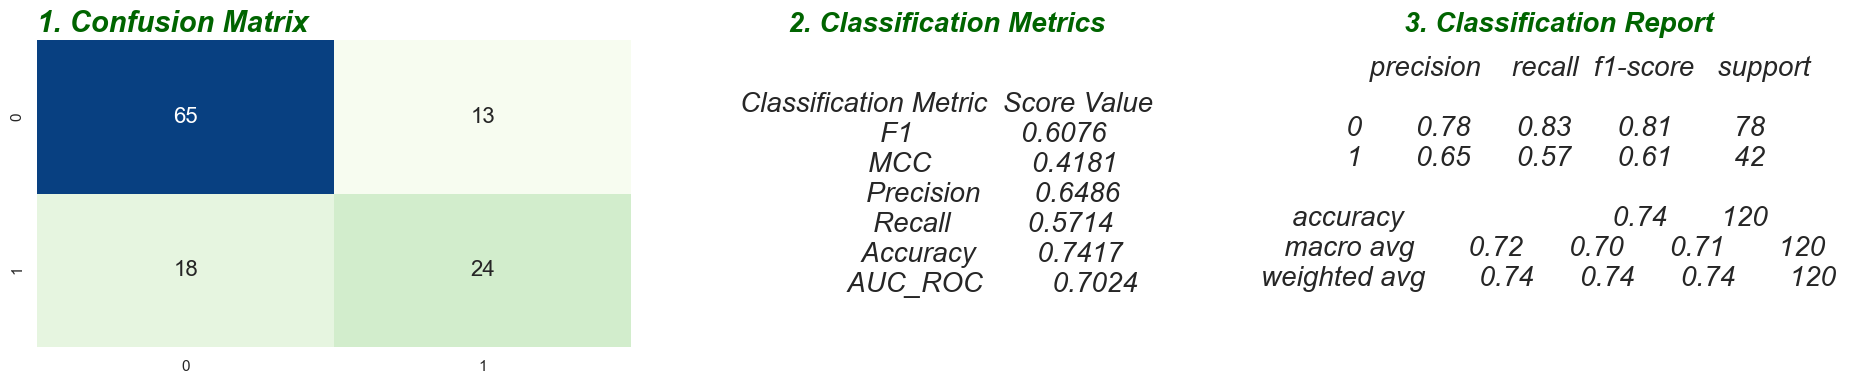

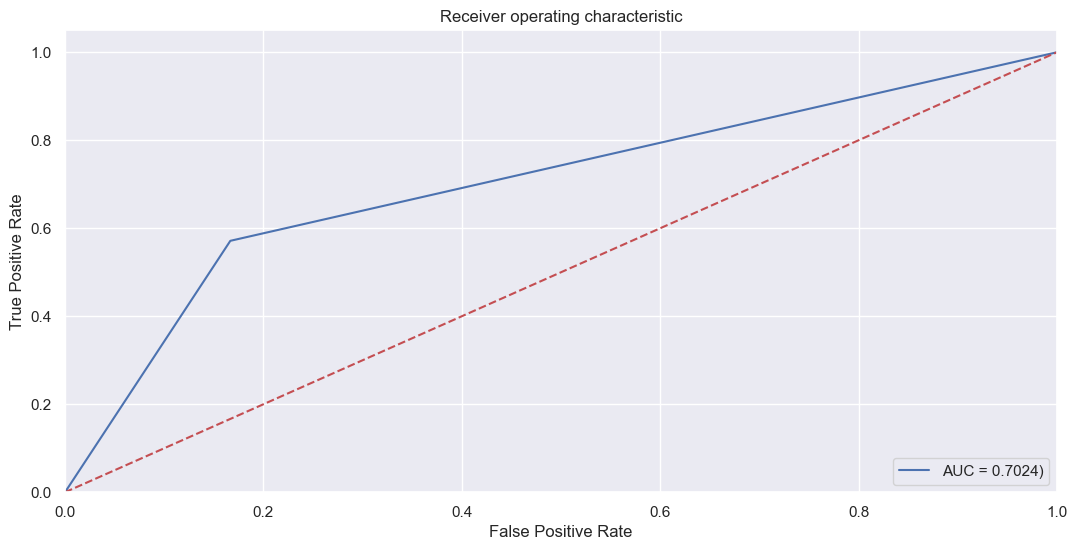

In [72]:
lr_poly_steps = poly_preprocessor_steps + [('lr', LogisticRegression())]
lr_poly_clf = Pipeline(lr_poly_steps)

lr_poly_clf = train_and_report(lr_poly_clf, X_train, y_train, X_test, y_test, "Polynomial Logistic Regression")

#### 4.2.5. SMOTE Polynomial Logistic Regression

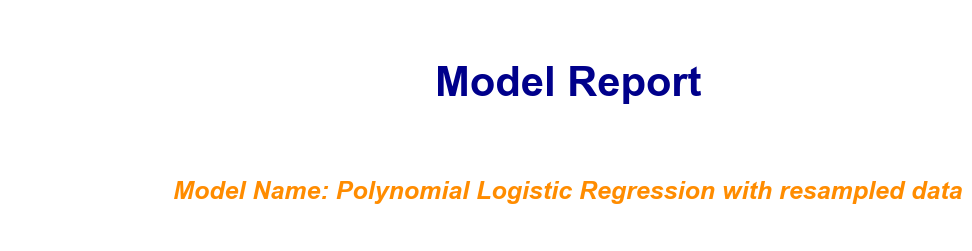

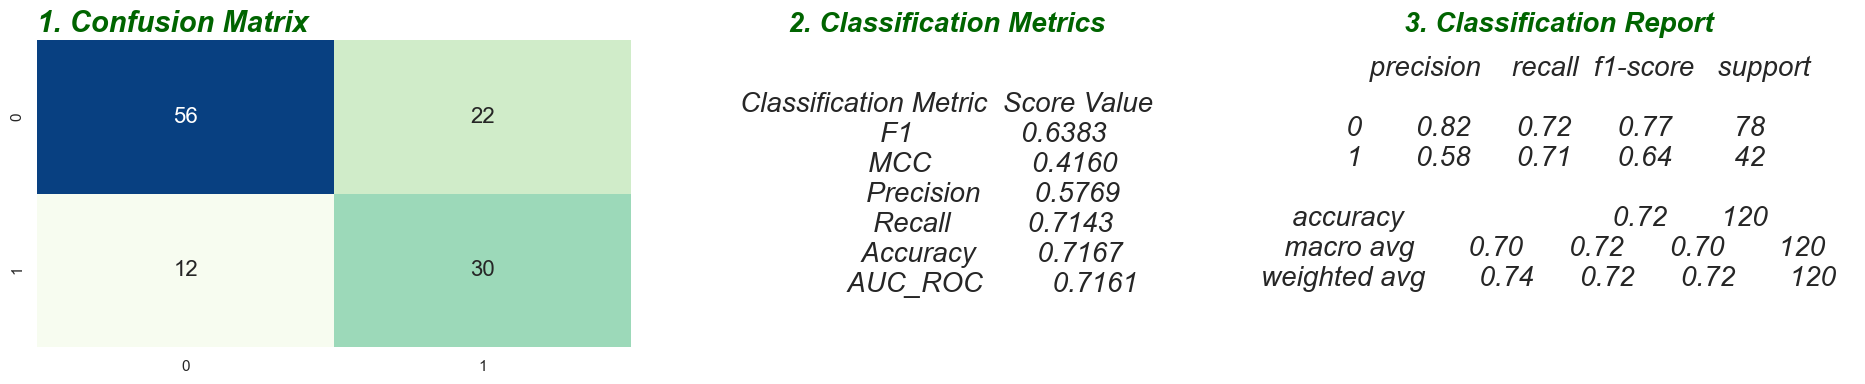

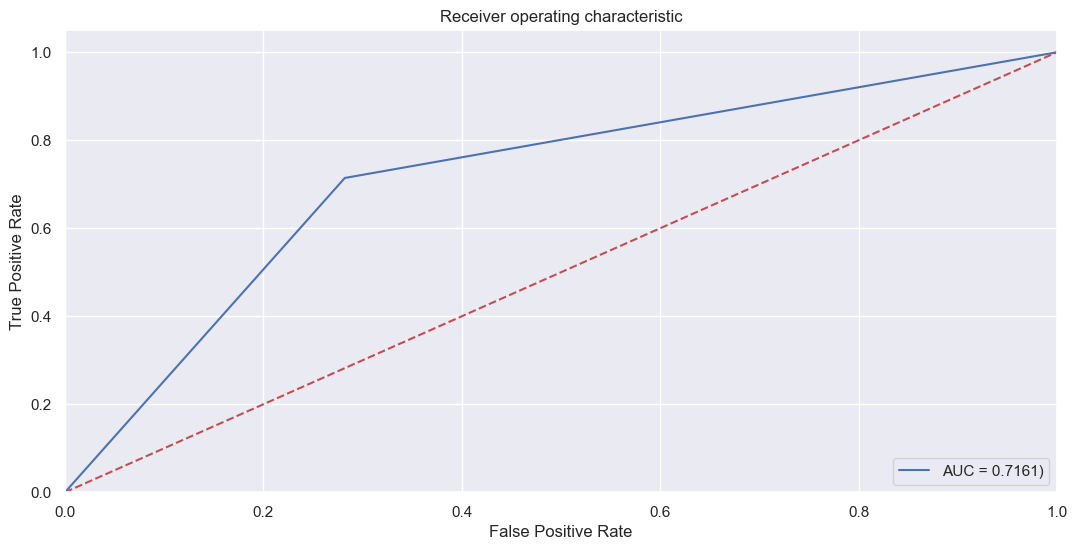

In [74]:
lr_poly_sm_steps = poly_preprocessor_steps + [('lr', LogisticRegression())]
lr_poly_sm_clf = Pipeline(lr_poly_sm_steps)

lr_poly_sm_clf = train_and_report(lr_poly_sm_clf, X_train_res, y_train_res, X_test, y_test, "Polynomial Logistic Regression with resampled data")

#### 4.2.6. The best Logistic Regression and hyperparameter tuning


| Models      | MCC | f1-score(%) | AUC_ROC (%) | Accuracy (%) |
|-------------|--------------------------|----------------------|-----|----|
| **1. Logistic Regression** | 52 | 62 | 75 | 93.9 |
| **2. Logistic Regression with transformed data** | 54 | 65 | 76 | 94.3 |
| **3. Logistic Regression with transformed data and Oversampling** | 89 | 60 | 89 | 88.5 |
| **4. Polynomial Logistic Regression with transformed data** | 89 | 60 | 89 | 88.5 |
| **5. Polynomial Logistic Regression with transformed data and Oversampling** | 89 | 60 | 89 | 88.5 |

/Users/baotri/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/baotri/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

Best params for the model: {'C': 10, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


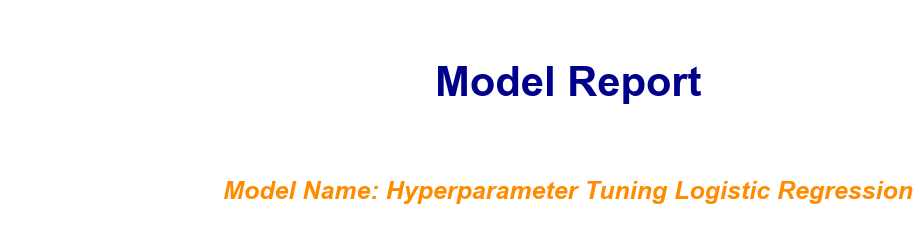

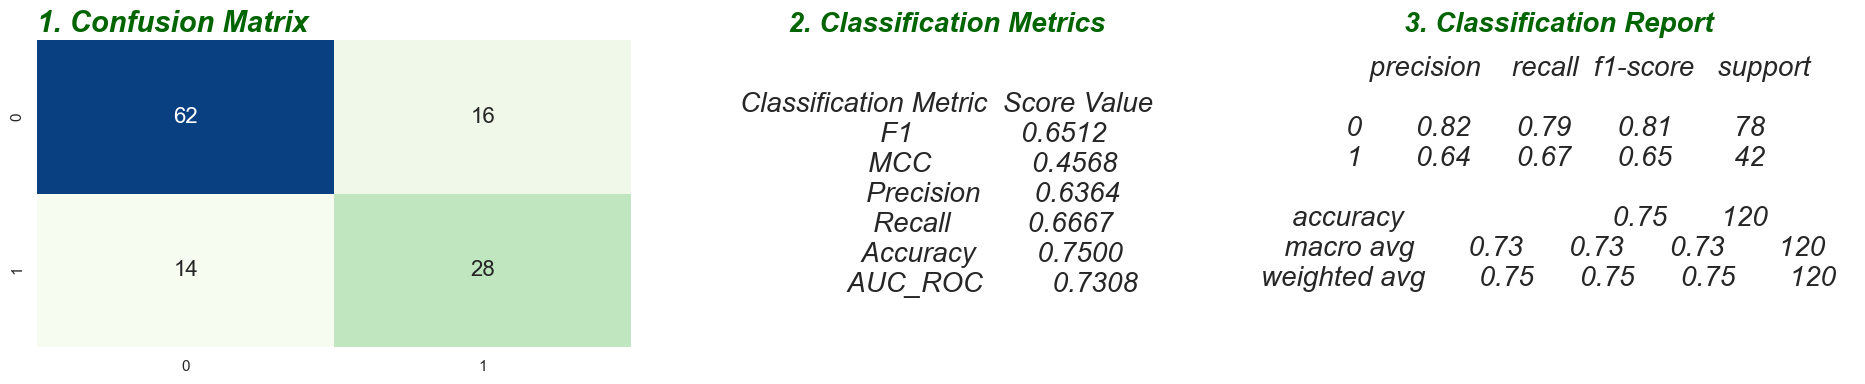

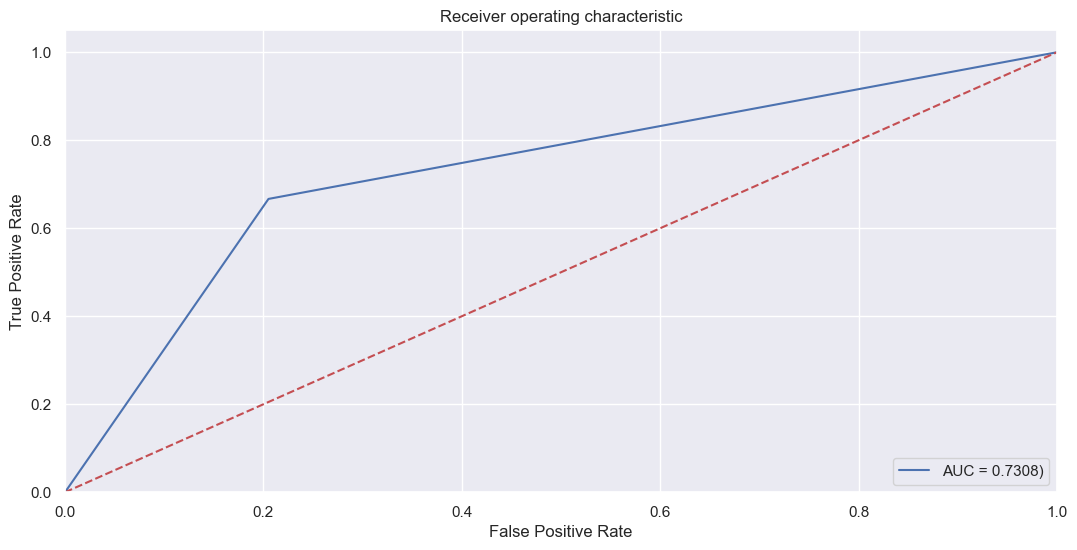

In [76]:
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 300], 'solver': ['lbfgs'] }

skf = StratifiedKFold(n_splits = 10)

lr_tuned_clf = GridSearchCV(estimator=LogisticRegression(), param_grid = params, n_jobs = -1, cv = skf)

lr_tuned_clf = train_and_report(lr_tuned_clf, X_train, y_train, X_test, y_test, "Hyperparameter Tuning Logistic Regression", grid=True)

### 4.3. Model 2: K-Nearest Neighbor 

#### 4.3.1. K-Nearest Neighbor

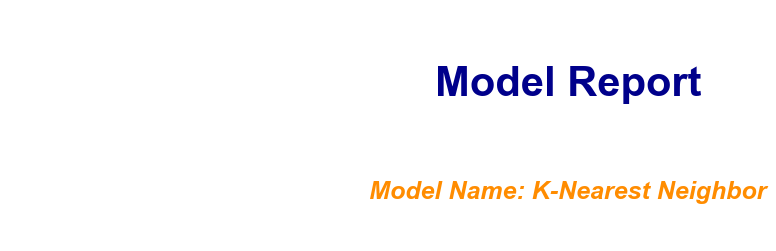

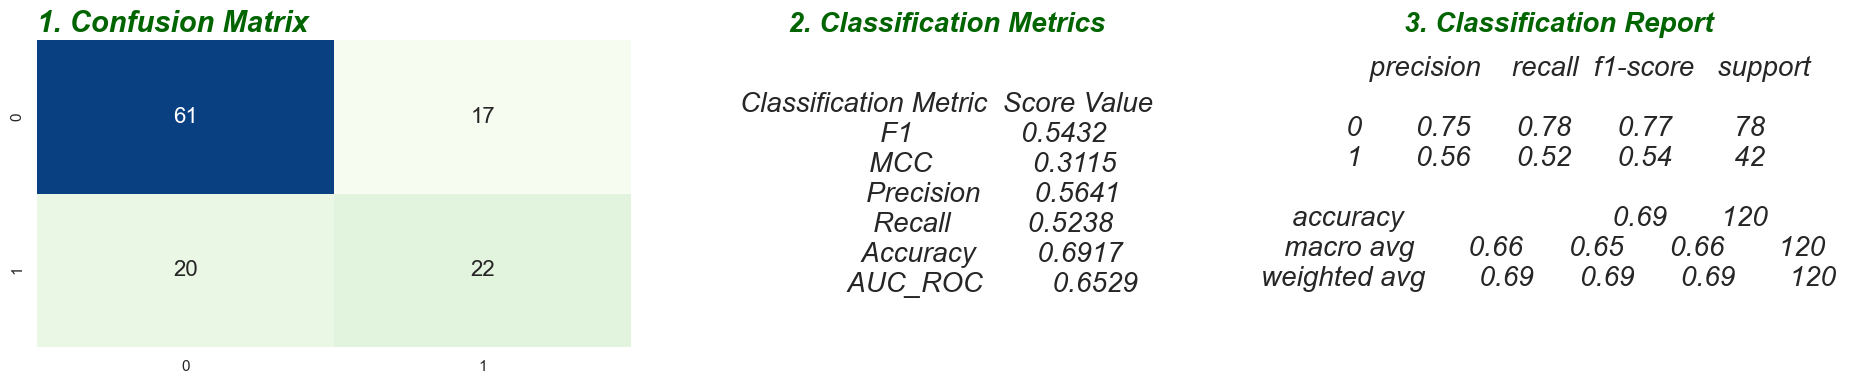

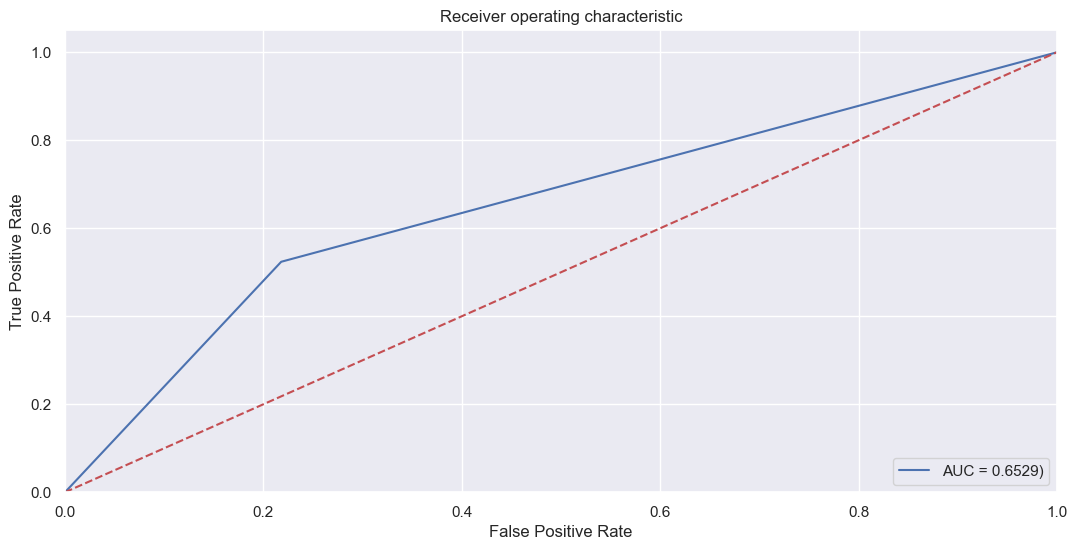

In [79]:
knn_clf = KNeighborsClassifier()

knn_clf = train_and_report(knn_clf, X_train, y_train, X_test, y_test, "K-Nearest Neighbor")

#### 4.3.2. K-Nearest Neighbor with Transformed Data

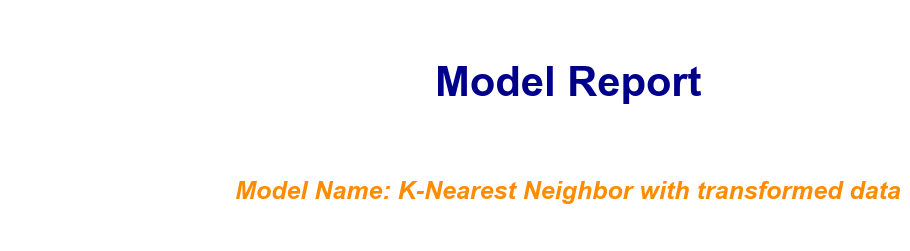

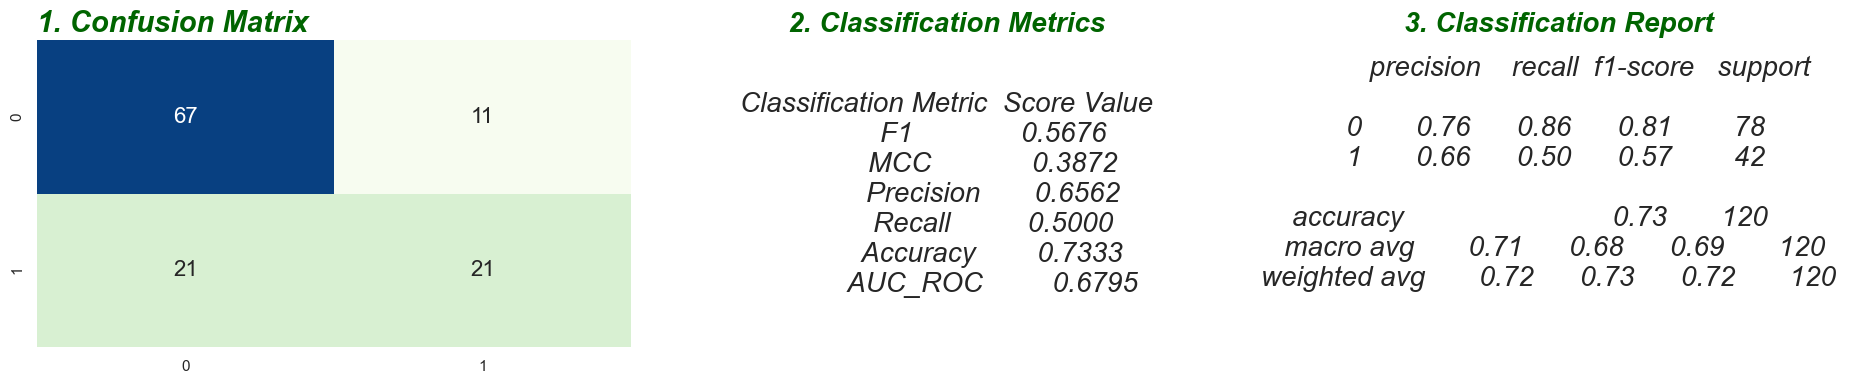

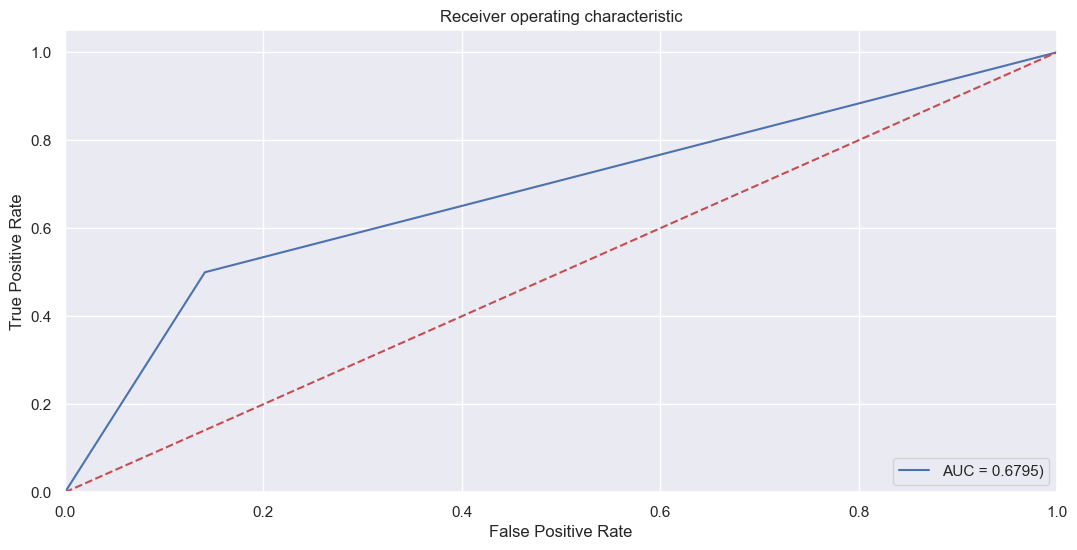

In [81]:
knn_steps = preprocessor_steps + [('knn', KNeighborsClassifier())]
knn_clf = Pipeline(knn_steps)

knn_clf = train_and_report(knn_clf, X_train, y_train, X_test, y_test, "K-Nearest Neighbor with transformed data")

#### 4.3.3 SMOTE K-Nearest Neighbor

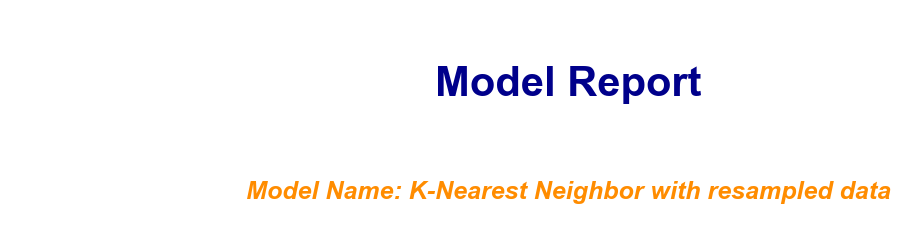

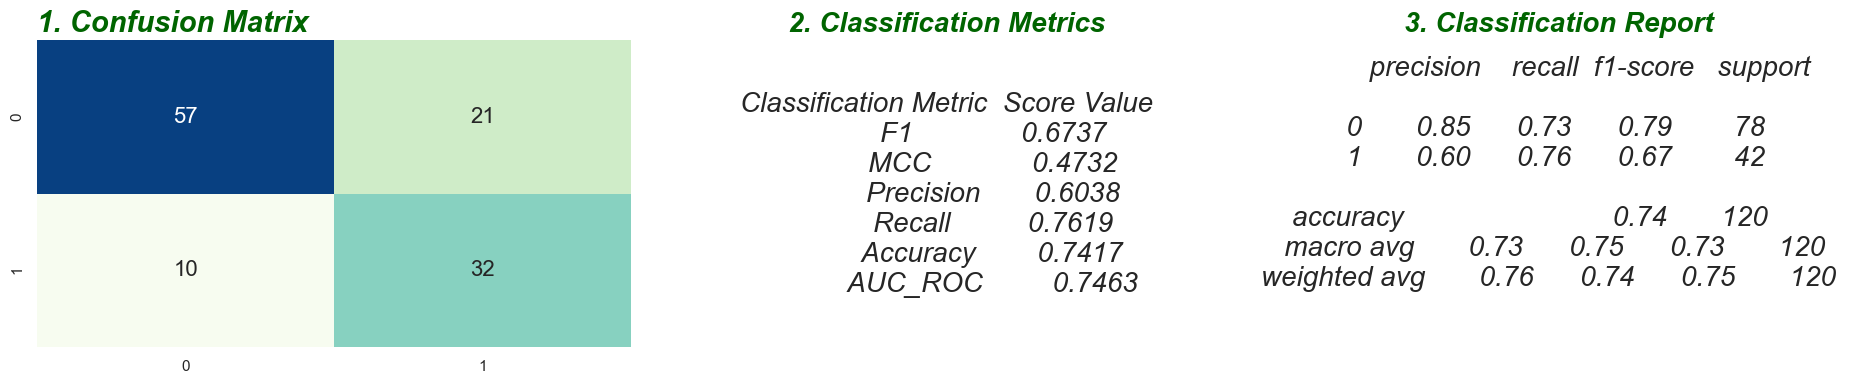

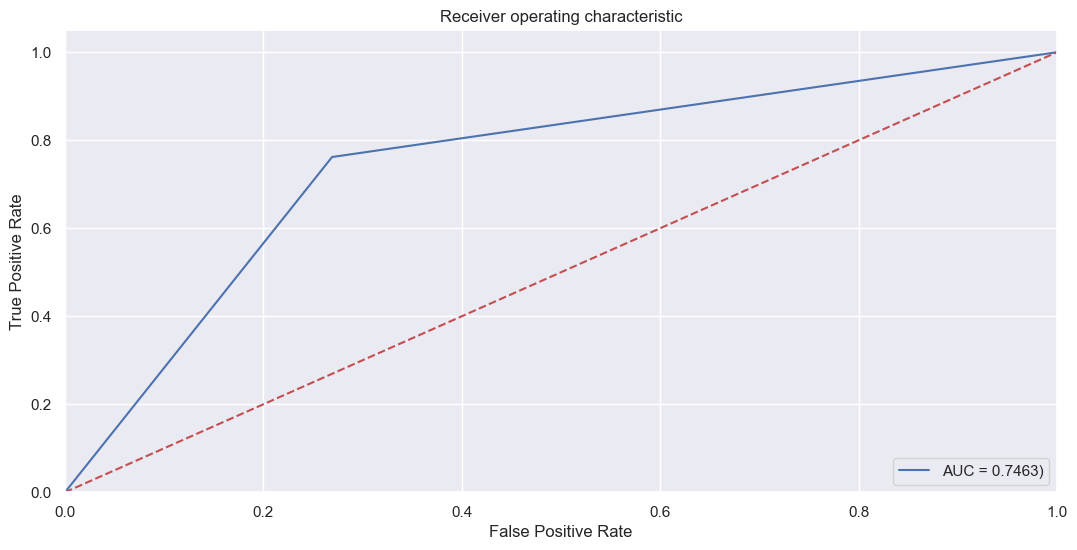

In [83]:
knn_sm_steps = preprocessor_steps + [('knn', KNeighborsClassifier())]
knn_sm_clf = Pipeline(knn_sm_steps)

knn_sm_clf = train_and_report(knn_sm_clf, X_train_res, y_train_res, X_test, y_test, "K-Nearest Neighbor with resampled data")

#### 4.3.4 Choosing the best KNN model and hyperparameter tuning

| Models      | MCC | f1-score(%) | AUC_ROC (%) | Accuracy (%) |
|-------------|--------------------------|----------------------|-----|----|
| **1. K-Nearest Neighbor** | 52 | 62 | 75 | 93.9 |
| **2. K-Nearest Neighbor with transformed data** | 54 | 65 | 76 | 94.3 |
| **3. K-Nearest Neighbor with transformed data and Oversampling** | 89 | 60 | 89 | 88.5 |

Best params for the model: {'knn__algorithm': 'auto', 'knn__n_neighbors': 7, 'knn__weights': 'distance'}


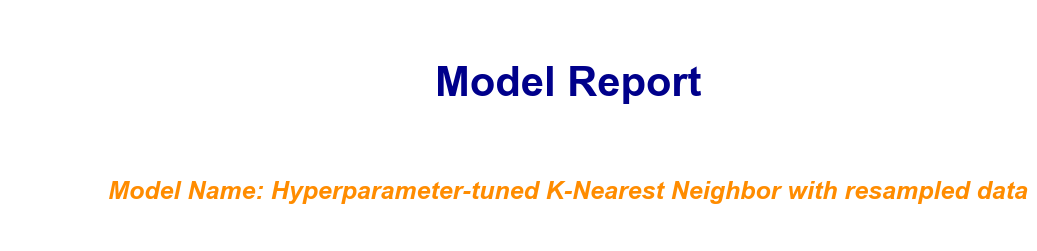

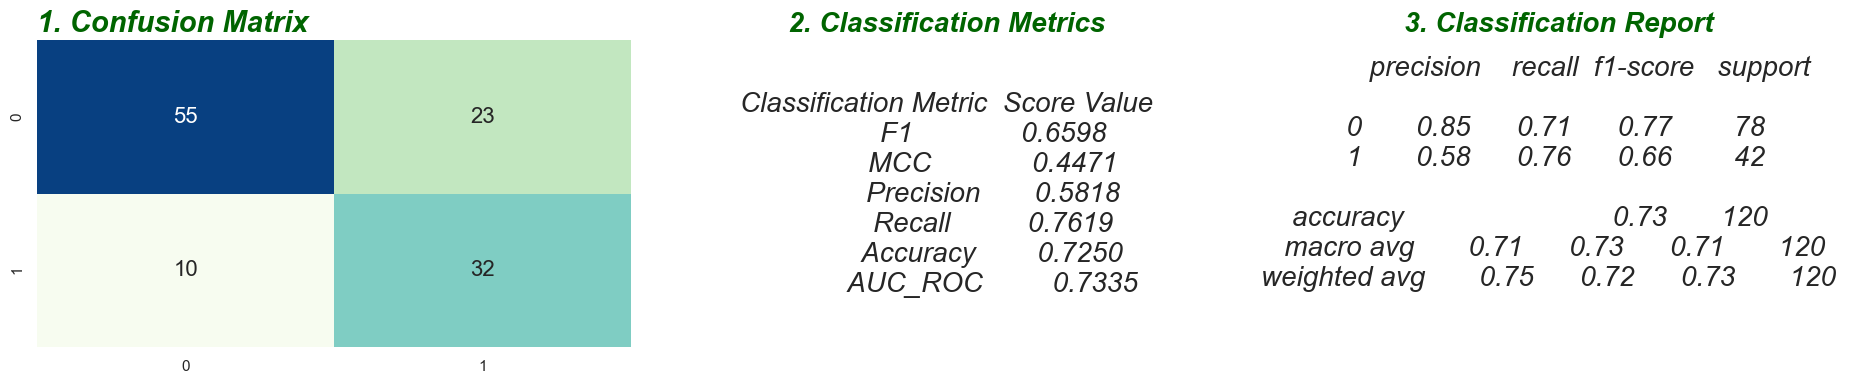

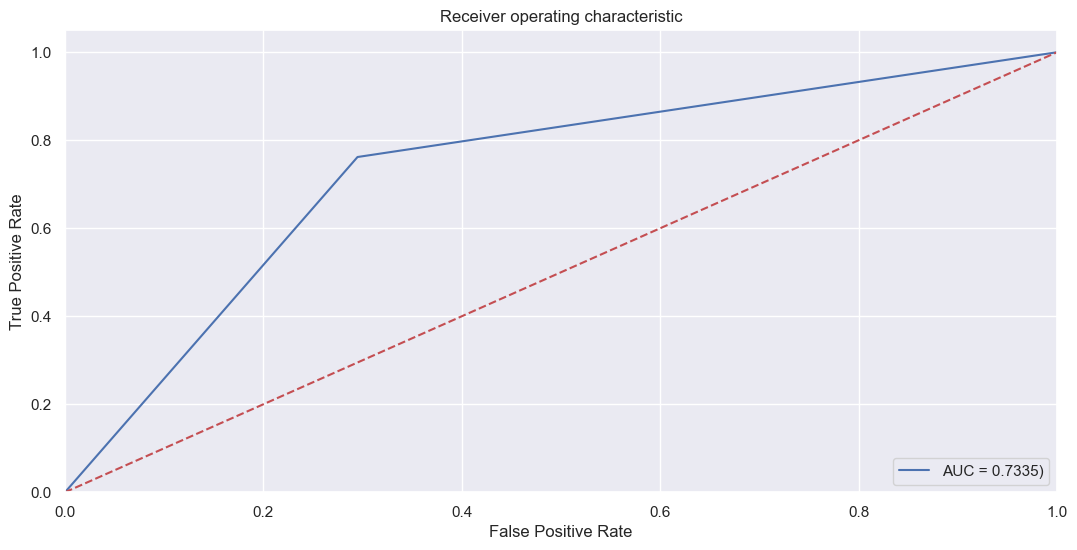

In [85]:
params = {'knn__n_neighbors': list(range(1, 40, 2)), 'knn__weights': ['uniform', 'distance'],
          'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}


skf = StratifiedKFold(n_splits = 5)
knn_tune_clf = Pipeline(knn_sm_steps)

knn_tuned_clf_grid = GridSearchCV(estimator=knn_tune_clf, param_grid = params, n_jobs = -1, cv = skf)

knn_tuned_clf_grid = train_and_report(knn_tuned_clf_grid, X_train_res, y_train_res, X_test, y_test, "Hyperparameter-tuned K-Nearest Neighbor with resampled data", grid=True)

### 4.4. Model 3: Random Forest

#### 4.4.1. Random Forest Classifier

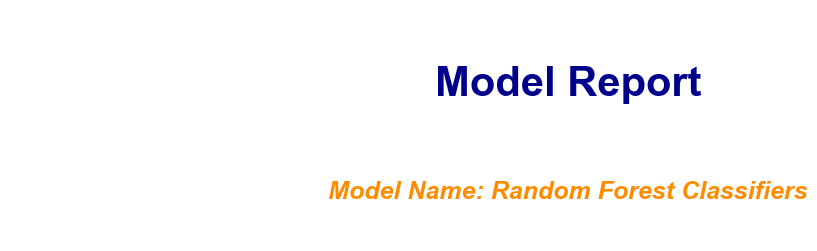

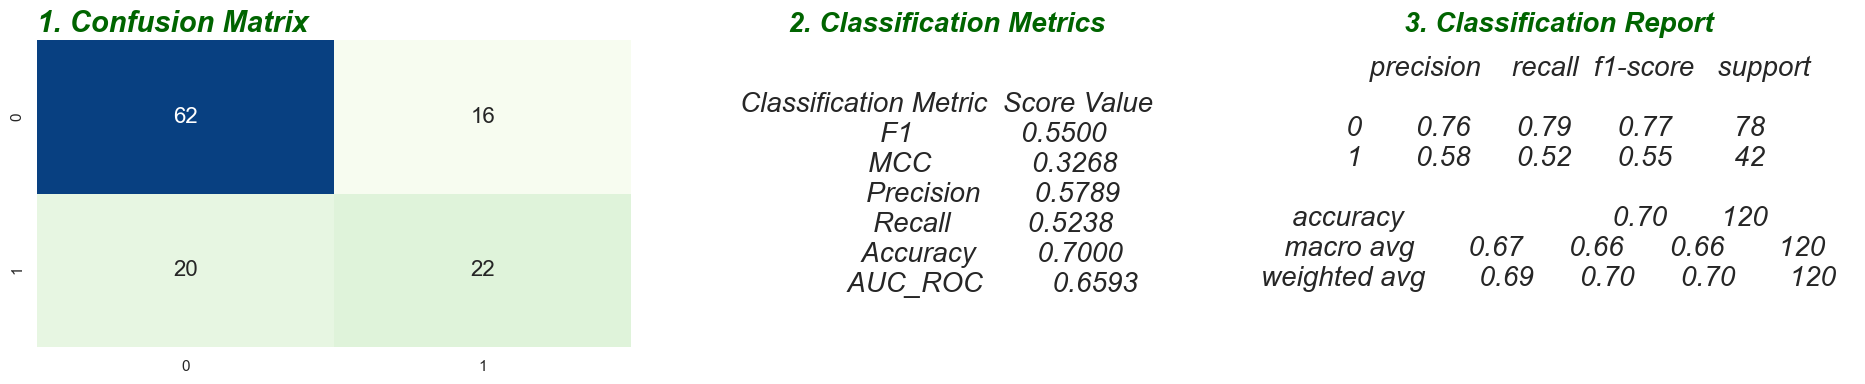

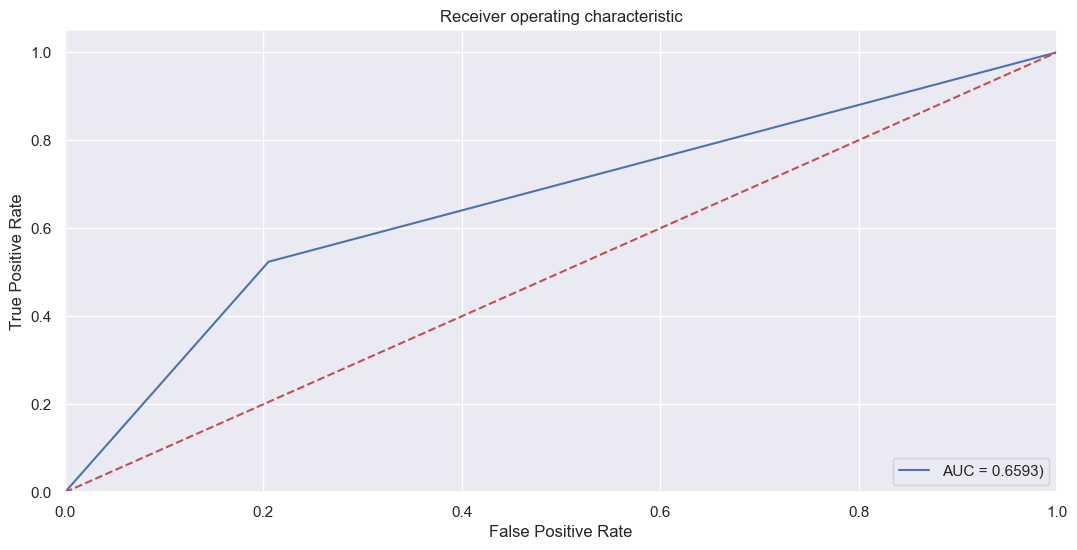

In [88]:
rf_clf = RandomForestClassifier()

rf_clf = train_and_report(rf_clf, X_train, y_train, X_test, y_test, "Random Forest Classifiers")

#### 4.4.2 SMOTE Random Forest

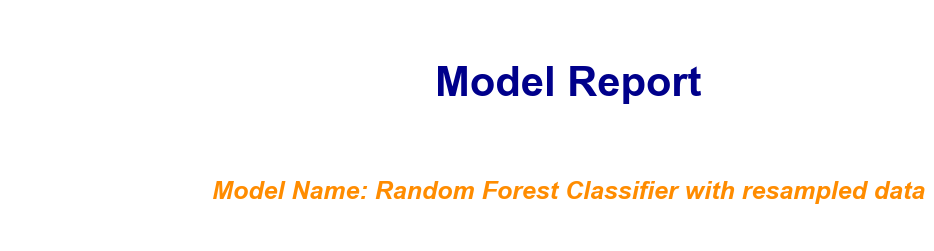

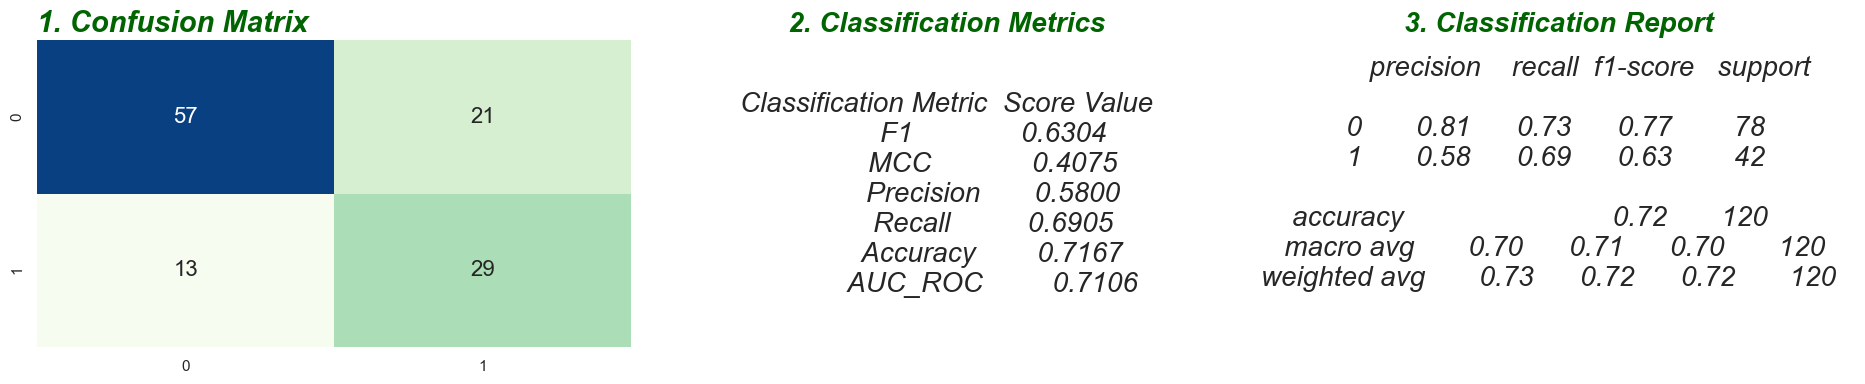

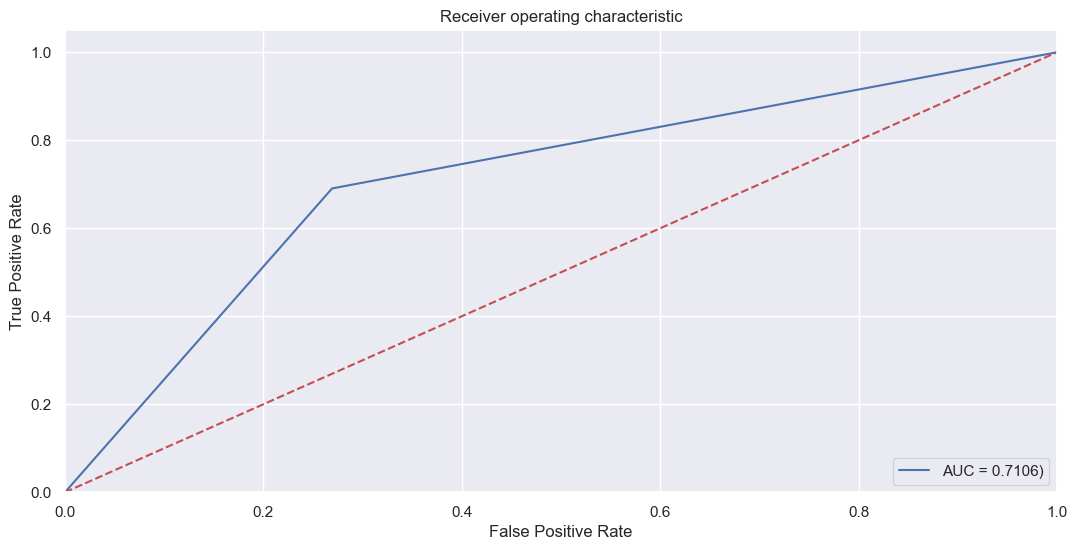

In [90]:
rf_sm_steps = preprocessor_steps + [('rf', RandomForestClassifier())]
rf_sm_clf = Pipeline(rf_sm_steps)

lr_sm_clf = train_and_report(rf_sm_clf, X_train_res, y_train_res, X_test, y_test, 'Random Forest Classifier with resampled data')

#### 4.4.3 Choosing the best Random Forest Classifier and hyperparameter tuning

| Models      | MCC | f1-score(%) | AUC_ROC (%) | Accuracy (%) |
|-------------|--------------------------|----------------------|-----|----|
| **1. Random Forest Classifier** | 52 | 62 | 75 | 93.9 |
| **3. Random Forest Classifier with Oversampling** | 89 | 60 | 89 | 88.5 |

In [ ]:
params = {"rf__max_depth": range(1, 10), 
              "rf__max_features": randint(1, 20), 
              "rf__min_samples_leaf": randint(25, 50),
              "rf__min_samples_split":range(50, 100, 2),
              "rf__n_estimators": range(1000, 8000, 500),
              "rf__bootstrap": [True, False]}


skf = StratifiedKFold(n_splits = 5)
rf_tune_clf = Pipeline(rf_sm_steps)

rf_tuned_clf_grid = RandomizedSearchCV(estimator=rf_tune_clf, param_distributions = params, cv = 5)

rf_tuned_clf_grid = train_and_report(rf_tuned_clf_grid, X_train_res, y_train_res, X_test, y_test, "Hyperparameter-tuned Random Forest Classifiers with resampled data ", grid=True)

### 4.5. Evaluation

The confusion matrix is another metric that is often used to measure the performance of a classification algorithm, which contains information about the actual and the predicted class.

Metrics that can be calculated from confusion matrix:
* **Precision**: When it predicts the positive result, how often is it correct? i.e. limit the number of false positives.
* **Recall**: When it is actually the positive result, how often does it predict correctly? i.e. limit the number of false negatives.
* **f1-score**: Harmonic mean of precision and recall.

The confusion matrix for class 1 (Accepted) would look like:

|                        | Predicted: 0 (Not Accepted) | Predicted: 1 (Accepted)|
|------------------------|-----------------------------|------------------------|
|**Actual: 0 (Not Accepted)**| True Negatives              | False Positives        |
|**Actual: 1 (Accepted)**    | False Negatives             | True Positives         |

* **Precision would tell us cases where actually the personal loan wasn't accepted by the customer but we predicted it as accepted.**
* **Recall would tell us cases where actually the personal was accepted by the customer but we predicted it as not accepted.**

In our case, it would be recall that would hold more importance then precision. So choosing recall and f1-score which is the harmonic mean of both precision and recall as evaluation metric, particularly for class 1.

Further, AUC-ROC curve is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s. By analogy, higher the AUC, better the model is at distinguishing between people developing `Sepssis` and people not developing `Sepssis` [source](https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5).

Additionally, we also tried **oversampling**, which is one of common ways to tackle the issue of imbalanced data. Over-sampling refers to various methods that aim to increase the number of instances from the underrepresented class in the data set. Out of the various methods, we chose Synthetic Minority Over-Sampling Technique (SMOTE). SMOTE’s main advantage compared to traditional random naive over-sampling is that by creating synthetic observations instead of reusing existing observations, classifier is less likely to overfit.

Thus based on our evaluation metric, the scores of the models we tried are as below:

| Models      | Recall Score for Class 1 (%) | f1-score for Class 1 (%) | ROC AUC (%) | Accuracy (%) |
|-------------|--------------------------|----------------------|-----|----|
| **1. Hyperparameter-tuned Logistic Regression** | 52 | 62 | 75 | 93.9 |
| **2. Hyperparameter-tuned K-Nearest Neighbor with transformed data and Oversampling** | 89 | 60 | 89 | 88.5 |
| **3. Hyperparameter-tuned Random Forest Classifier with Oversampling** | 89 | 60 | 89 | 88.5 |

It can be seen that **Model 3** gives a better measures overall against others. 

## 5. Predict the test set

In [ ]:
patients_df_test = pd.read_csv(r'datasets/Paitients_Files_Test.csv')

patients_df_test.drop(columns = ["ID", "PR", "SK", "Insurance"], inplace=True) 

prediction = clf3.predict(patients_df_test) 
 
prediction_df = pd.read_csv('s3749560_predictions.csv', delimiter=',') 
 
#input the prediction to the Sepssis  

prediction_df.loc[:, 'Sepssis'] = prediction 
 
#convert back to Negative and Positive  

seps_reverse = {0: 'Negative', 1: 'Positive'}  prediction_df['Sepssis'] = prediction_df['Sepssis'].map(seps_reverse)   
prediction_df.to_csv('03_TESTPREDICT_NguyenBaoTri_s3749560.csv', index=False) 